# Operazioni preliminari

In [ ]:
#Carichiamo le llibrerie necessarie per l'analisi
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportion_confint
import requests
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from scipy import stats
import math

import sklearn as sn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    confusion_matrix,
    classification_report
)

In [ ]:
# Carico il dataset direttamente da GitHub
url = "https://raw.githubusercontent.com/LucaA0111/Progetto-Architettura-Dati/refs/heads/main/diabetes.csv"
df = pd.read_csv(url)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**Descrizione delle feature del dataset Diabetes**

* **Pregnancies**:
  numero di gravidanze avute dalla persona; può essere associato a cambiamenti metabolici rilevanti per il rischio di diabete.

* **Glucose:**
livello di glucosio nel plasma misurato dopo un test di tolleranza al glucosio; è uno degli indicatori principali per la diagnosi del diabete.

* **BloodPressure:**
pressione sanguigna diastolica (mm Hg); valori elevati possono essere correlati a disturbi metabolici e cardiovascolari.

* **SkinThickness:**
spessore della piega cutanea del tricipite (mm); fornisce una stima indiretta del grasso corporeo sottocutaneo.

* **Insulin:**
livello di insulina nel sangue (mu U/ml); indica la risposta dell’organismo al glucosio ed è utile per valutare possibili disfunzioni metaboliche.

* **BMI (Body Mass Index):**
indice di massa corporea, utilizzato per stimare il grado di adiposità; l’obesità è un noto fattore di rischio per il diabete di tipo 2.

* **DiabetesPedigreeFunction:**
misura sintetica della predisposizione genetica al diabete, basata sulla storia familiare.

* **Age:**
età della persona in anni; l’incidenza del diabete tende ad aumentare con l’età.

* **Outcome (variabile target):**
indica la presenza o assenza di diabete:

  * 0 = non diabetico

  * 1 = diabetico




In [ ]:
# Descrizione delle Features
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
#Numero totale di istanze e tipi
print(f"Numero di istanze nel dataset: {df.shape[0]}")
df.dtypes

Numero di istanze nel dataset: 768


,0
Pregnancies,int64
Glucose,int64
BloodPressure,int64
SkinThickness,int64
Insulin,int64
BMI,float64
DiabetesPedigreeFunction,float64
Age,int64
Outcome,int64


Il dataset presenta una particolarità rilevante: alcune variabili cliniche assumono il valore zero in numerose osservazioni, nonostante tale valore non sia fisiologicamente plausibile. In particolare, attributi come Glucose, BloodPressure, SkinThickness, Insulin e BMI non possono assumere valore nullo in individui viventi. Come riportato nella documentazione ufficiale del dataset, tali zeri rappresentano in realtà valori mancanti mascherati, introdotti per indicare l’assenza di misurazione. Al fine di gestire questo fenomeno senza ridurne la dimensionalità, è stata adottata una strategia di imputazione basata sul metodo dei k-nearest neighbors (KNN). Tale approccio consente di stimare i valori mancanti sfruttando la similarità tra le osservazioni, preservando le relazioni multivariate tra le feature. A differenza delle imputazioni basate su statistiche globali, il metodo KNN permette di mantenere una maggiore variabilità nei dati, risultando particolarmente adatto in contesti in cui le feature sono numeric e correlate tra loro, come nel caso di variabili cliniche.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# Dataset originale
df = pd.read_csv(
    "https://raw.githubusercontent.com/LucaA0111/Progetto-Architettura-Dati/main/diabetes.csv"
)

# Colonne con zeri non plausibili
invalid_zero_cols = [
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI"
]

# Zeri → NaN
df[invalid_zero_cols] = df[invalid_zero_cols].replace(0, np.nan)

# Feature / target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN Imputation
imputer = KNNImputer(n_neighbors=5, weights="distance")
X_train_imp_scaled = imputer.fit_transform(X_train_scaled)
X_test_imp_scaled = imputer.transform(X_test_scaled)

# INVERSIONE SCALING
X_train_imp = scaler.inverse_transform(X_train_imp_scaled)
X_test_imp = scaler.inverse_transform(X_test_imp_scaled)

# Ricostruzione DataFrame
X_train_imp = pd.DataFrame(X_train_imp, columns=X.columns, index=X_train.index)
X_test_imp = pd.DataFrame(X_test_imp, columns=X.columns, index=X_test.index)

# Dataset finale (QUESTO è df)
df = pd.concat([X_train_imp, X_test_imp])
df["Outcome"] = pd.concat([y_train, y_test])

# Stampo le prime 20 righe del dataframe per vedere se ha funzionato
df.head(200)




,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
353,1.0,90.0,62.0,12.000000,43.000000,27.2,0.580,24.0,0
711,5.0,126.0,78.0,27.000000,22.000000,29.6,0.439,40.0,0
373,2.0,105.0,58.0,40.000000,94.000000,34.9,0.225,25.0,0
46,1.0,146.0,56.0,29.202736,136.367950,29.7,0.564,29.0,0
682,0.0,95.0,64.0,39.000000,105.000000,44.6,0.366,22.0,0
...,...,...,...,...,...,...,...,...,...
571,2.0,130.0,96.0,17.537342,98.899532,22.6,0.268,21.0,0
98,6.0,93.0,50.0,30.000000,64.000000,28.7,0.356,23.0,0
631,0.0,102.0,78.0,40.000000,90.000000,34.5,0.238,24.0,0
455,14.0,175.0,62.0,30.000000,190.295812,33.6,0.212,38.0,1


# EDA (Esplorazione dei Dati)

## EDA MONOVARIATA (DISTRIBUZIONI DELLE VARIABILI)

**DISTRIBUZIONE VARIABILI NUMERICHE CONTINUE (ISTOGRMMA)**

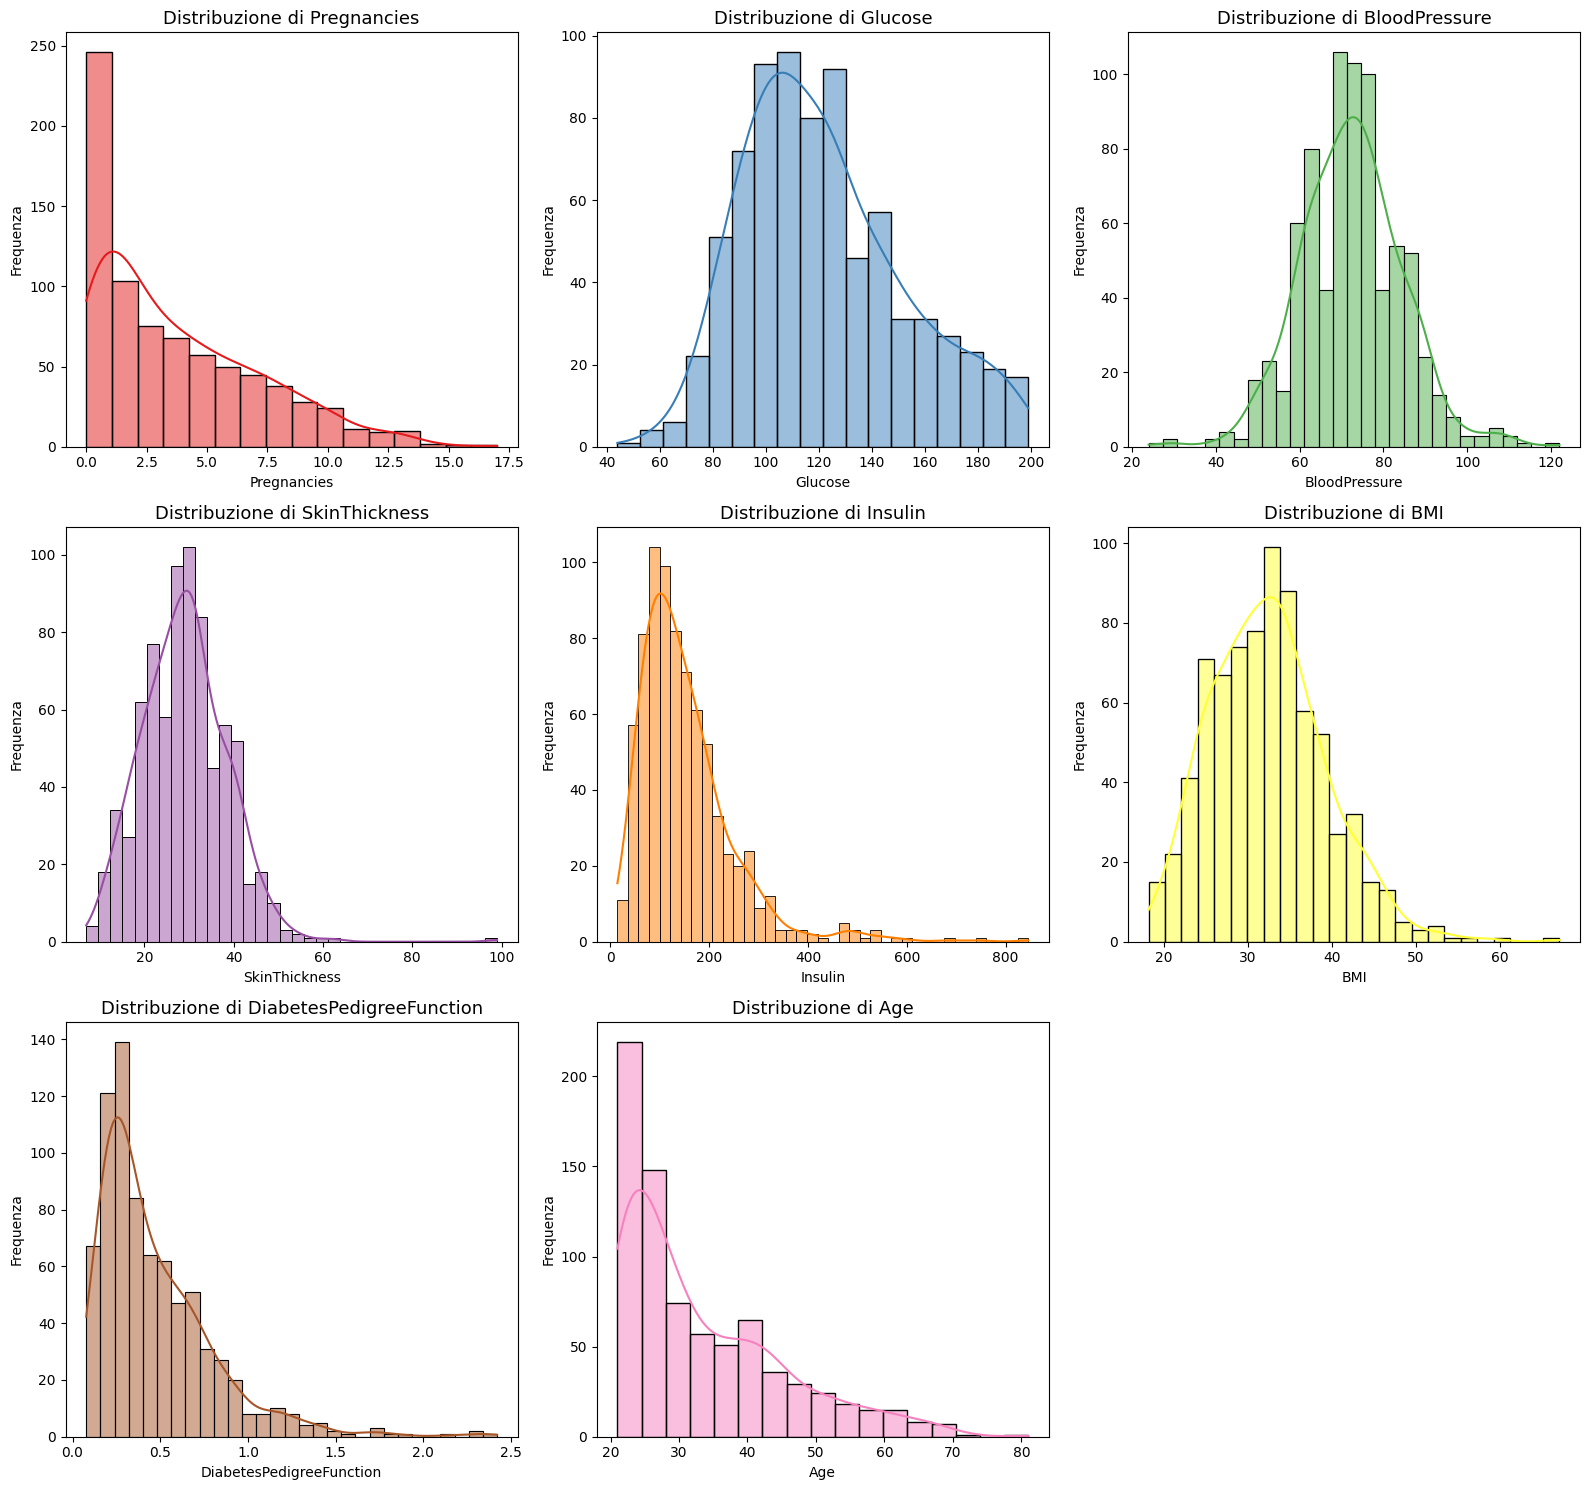

In [ ]:
# Selezione feature NON target
numerical_cols = df.drop(columns=["Outcome"]).columns.tolist()

# Layout grafici
n_cols = 3
n_rows = math.ceil(len(numerical_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
axes = axes.flatten()

# Palette con colori distinti
palette = sns.color_palette("Set1", len(numerical_cols))

# Plot distribuzioni
for i, col in enumerate(numerical_cols):
    sns.histplot(
        df[col],
        kde=True,
        ax=axes[i],
        color=palette[i],
        edgecolor="black"
    )
    axes[i].set_title(f"Distribuzione di {col}", fontsize=13)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequenza")

# Rimozione subplot vuoti
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()




**DISTRIBUZIONE VARIABILI CONTINUE (BOX PLOT)**

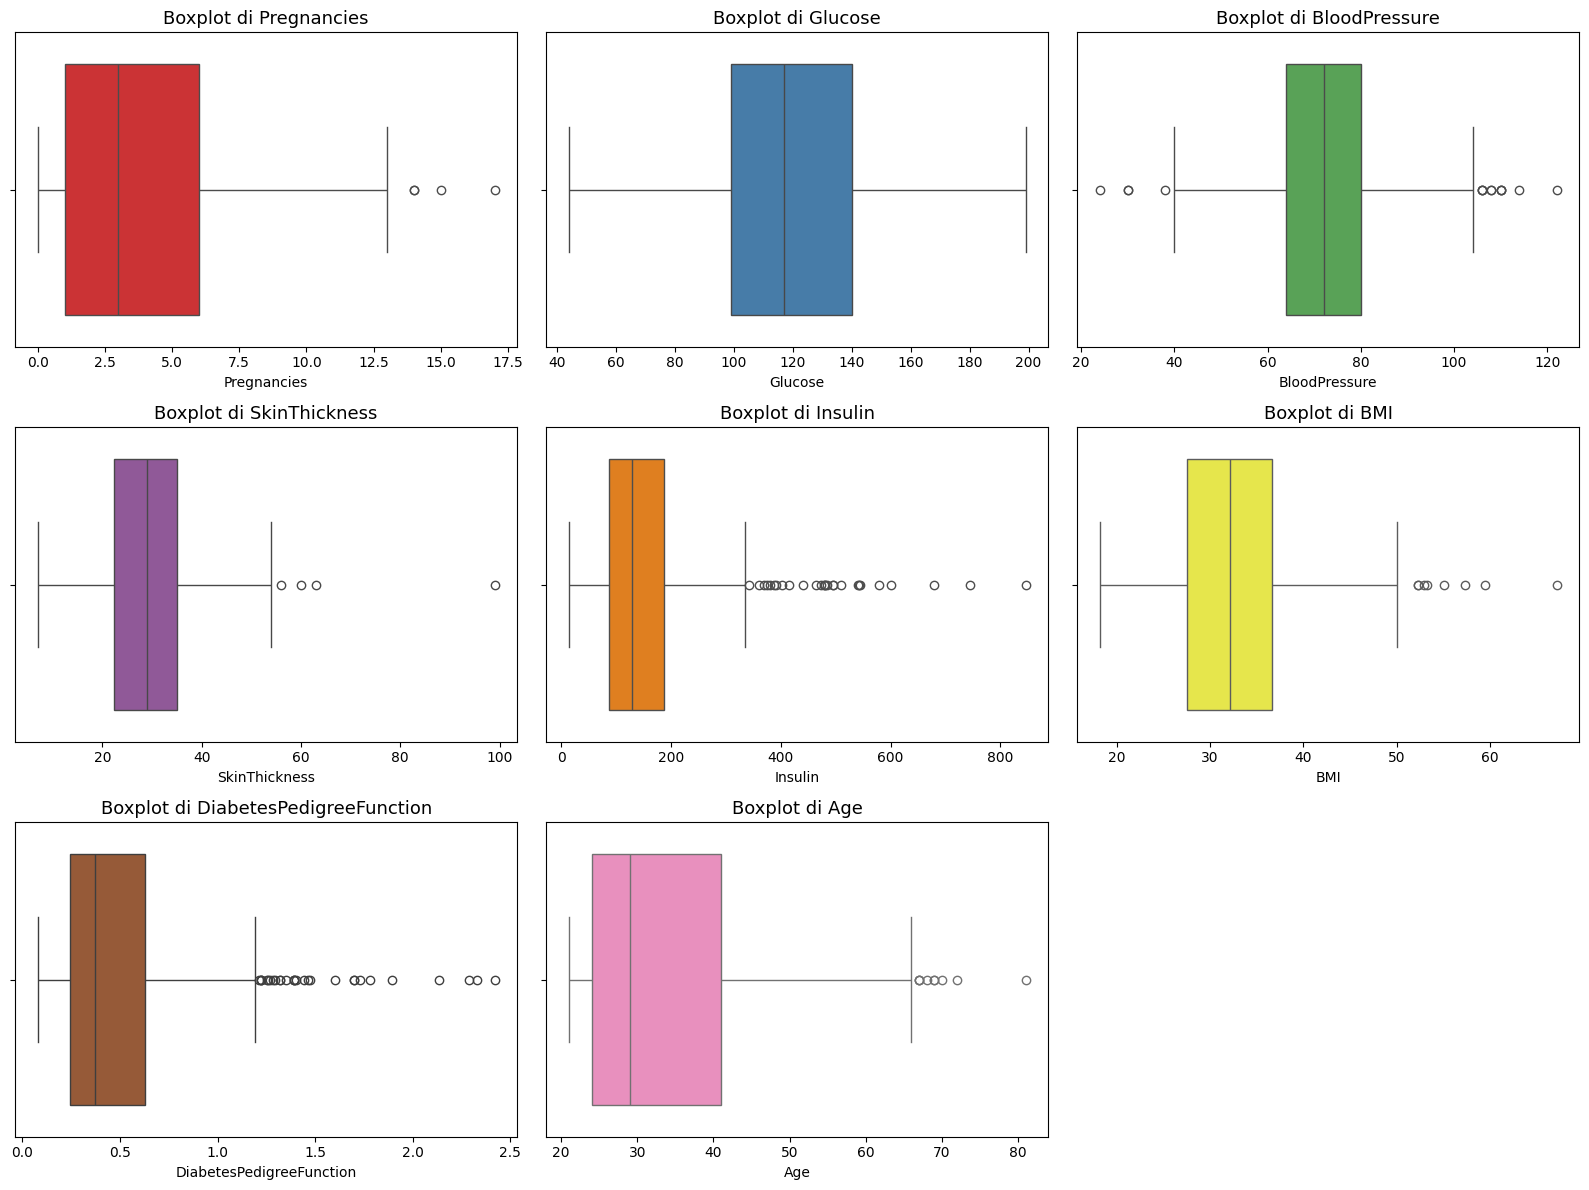

In [ ]:
# Feature NON target
numerical_cols = df.drop(columns=["Outcome"]).columns.tolist()

# Layout grafici
n_cols = 3
n_rows = math.ceil(len(numerical_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

palette = sns.color_palette("Set1", len(numerical_cols))

# Boxplot
for i, col in enumerate(numerical_cols):
    sns.boxplot(
        x=df[col],
        ax=axes[i],
        color=palette[i]
    )
    axes[i].set_title(f"Boxplot di {col}", fontsize=13)
    axes[i].set_xlabel(col)

# Rimozione subplot vuoti
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


/tmp/ipython-input-1973629215.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


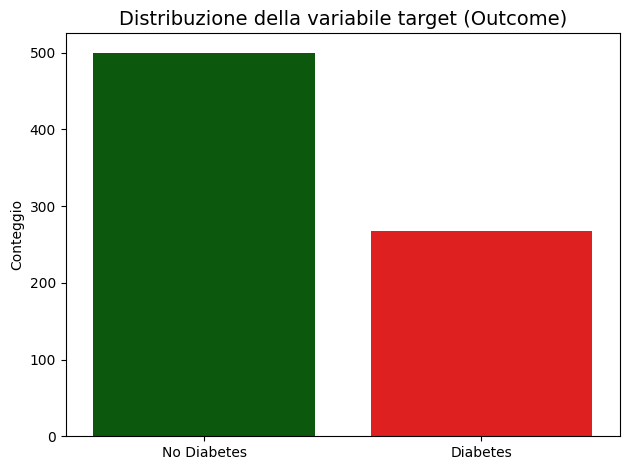

In [ ]:
# Mapping etichette target
target = "Outcome"

target_map = {
    0: "No Diabetes",
    1: "Diabetes"
}

labels = df[target].map(target_map)

target_palette = {
    "No Diabetes": "darkgreen",
    "Diabetes": "red"
}


sns.countplot(
    x=labels,
    palette=target_palette
)

plt.title("Distribuzione della variabile target (Outcome)", fontsize=14)
plt.xlabel("")
plt.ylabel("Conteggio")

plt.tight_layout()
plt.show()



## EDA MULTIVARIATA (DISTRIBUZIONI DELLA VARIABILI IN RELAZIONE AL TARGET)

**Distribuzione Variabili Continue in Relazione alla Variabile Target (ISTOGRAMMA)**

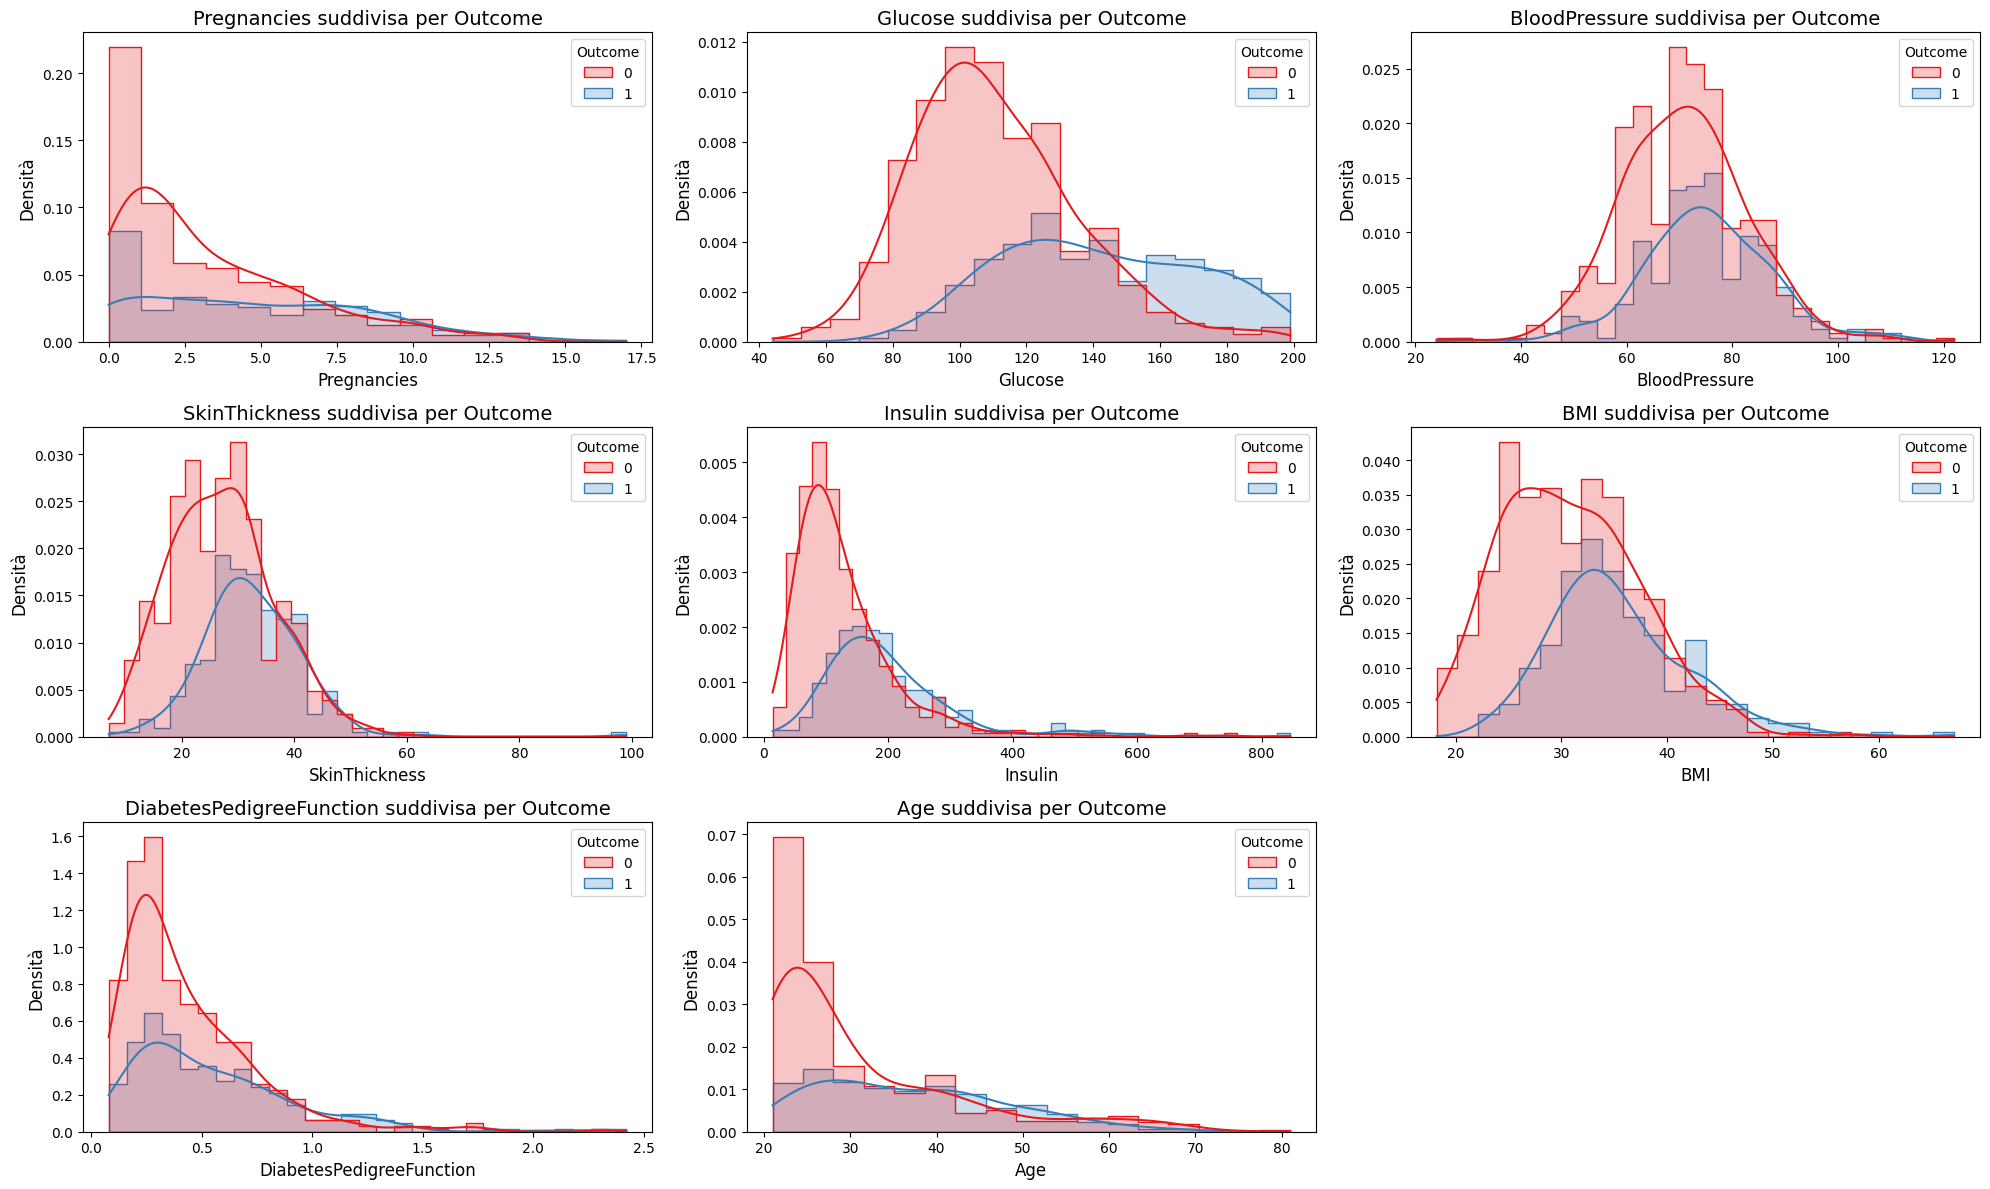

In [ ]:
target = "Outcome"

# Feature numeriche (NON target)
numerical_cols = df.drop(columns=[target]).columns.tolist()
n_features = len(numerical_cols)

# Layout automatico
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(20, 4 * n_rows)
)
axes = axes.flatten()

# Istogrammi + KDE per classe
for i, feature in enumerate(numerical_cols):
    sns.histplot(
        data=df,
        x=feature,
        hue=target,
        kde=True,
        element="step",
        stat="density",
        palette="Set1",
        ax=axes[i]
    )
    axes[i].set_title(
        f"{feature} suddivisa per Outcome",
        fontsize=14
    )
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel("Densità", fontsize=12)

# Rimozione subplot vuoti
for j in range(n_features, n_rows * n_cols):
    axes[j].axis("off")

plt.tight_layout()
plt.show()




**Distribuzione Variabili Continue in Relazione alla Variabile Target (BOX PLOT)**

/tmp/ipython-input-4168639752.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-4168639752.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-4168639752.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-4168639752.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-4168639752.py:20: FutureWarning: 

Passin

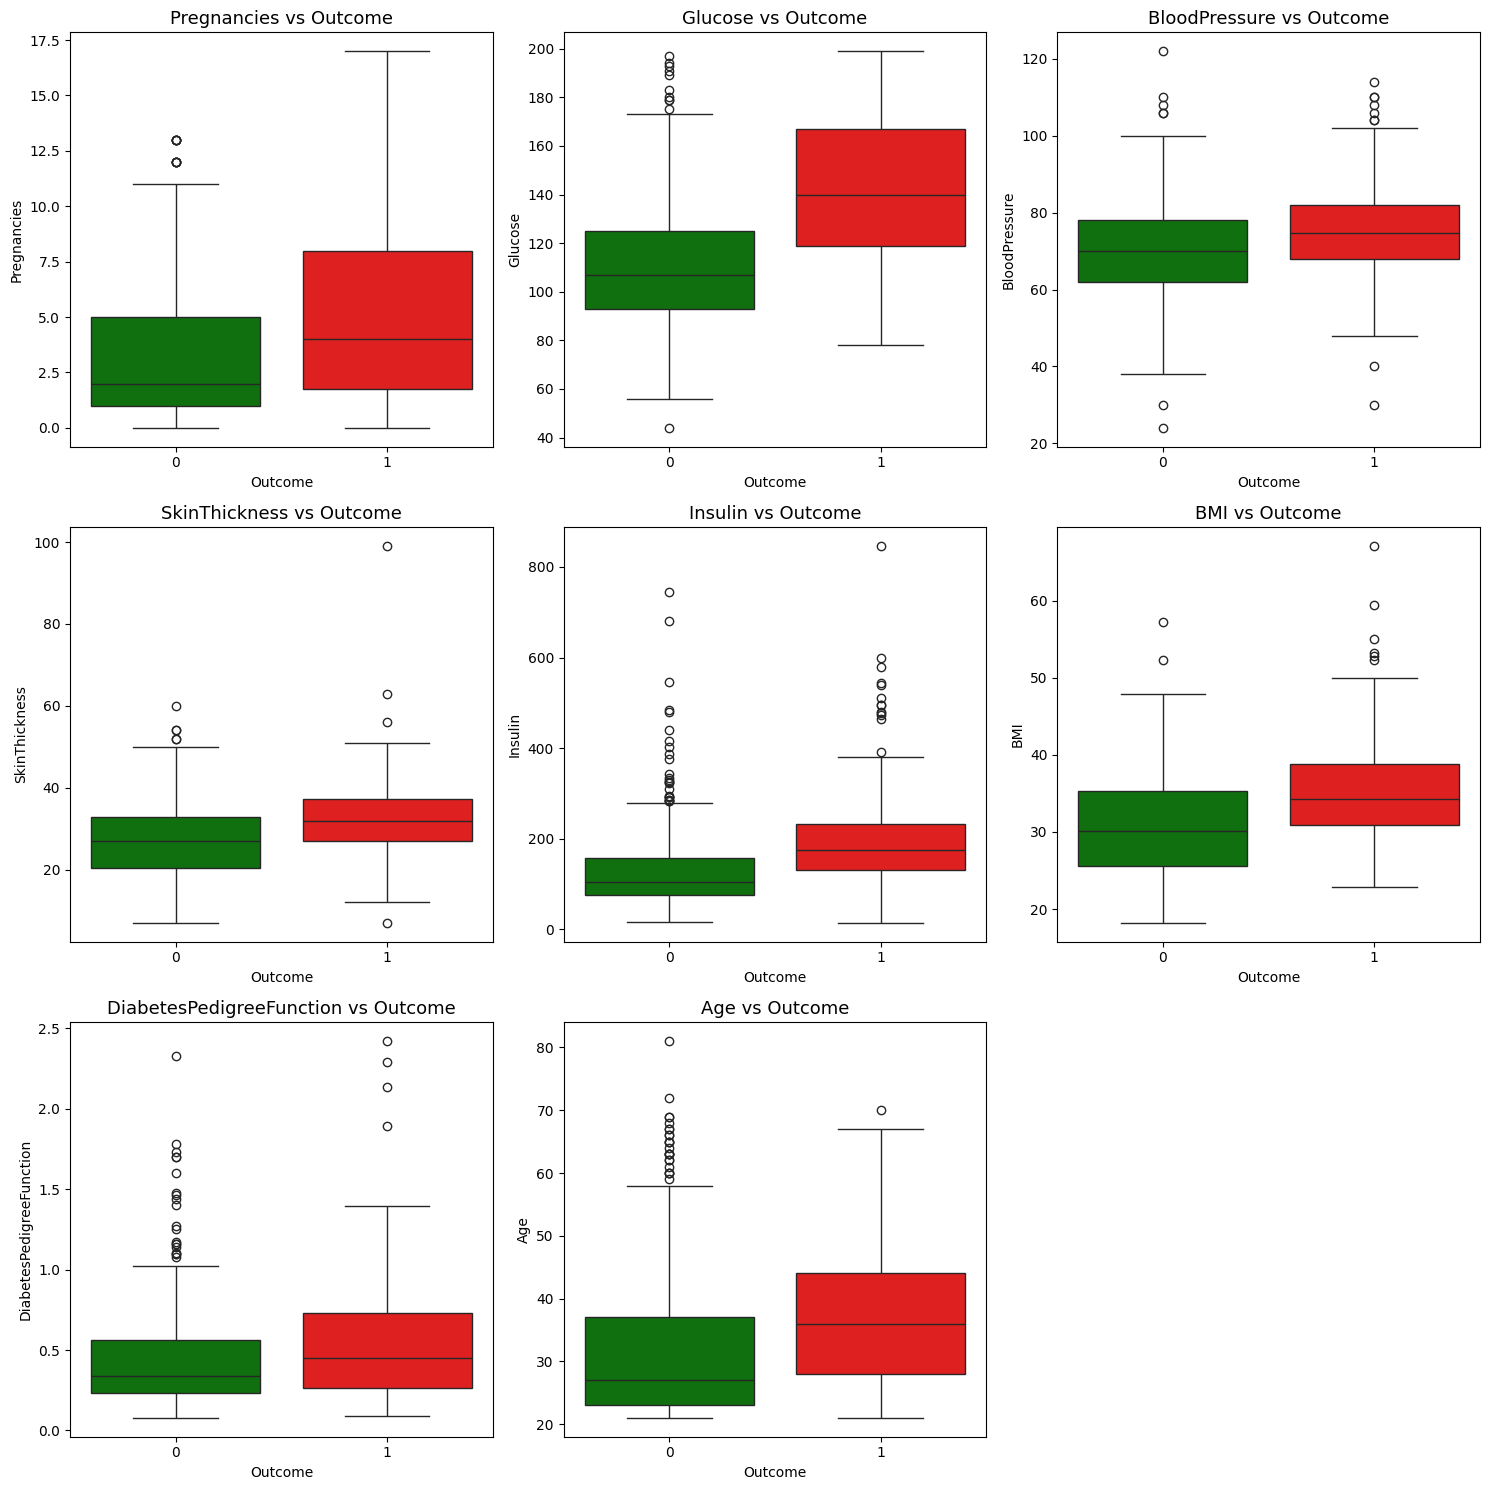

In [ ]:
# Target
target = "Outcome"

# Feature numeriche (NON target)
numerical_cols = df.drop(columns=[target]).columns.tolist()

# Layout grafici
n_cols = 3
n_rows = math.ceil(len(numerical_cols) / n_cols)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(15, 5 * n_rows)
)
axes = axes.flatten()

# Boxplot vs Target
for i, col in enumerate(numerical_cols):
    sns.boxplot(
        data=df,
        x=target,
        y=col,
        palette=["green", "red"],
        ax=axes[i]
    )
    axes[i].set_title(f"{col} vs Outcome", fontsize=13)
    axes[i].set_xlabel("Outcome")
    axes[i].set_ylabel(col)

# Rimozione subplot vuoti
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



## ANALISI DI CORRELAZIONE

**CORRELAZIONE TRA VARIABILI CONTINUE**

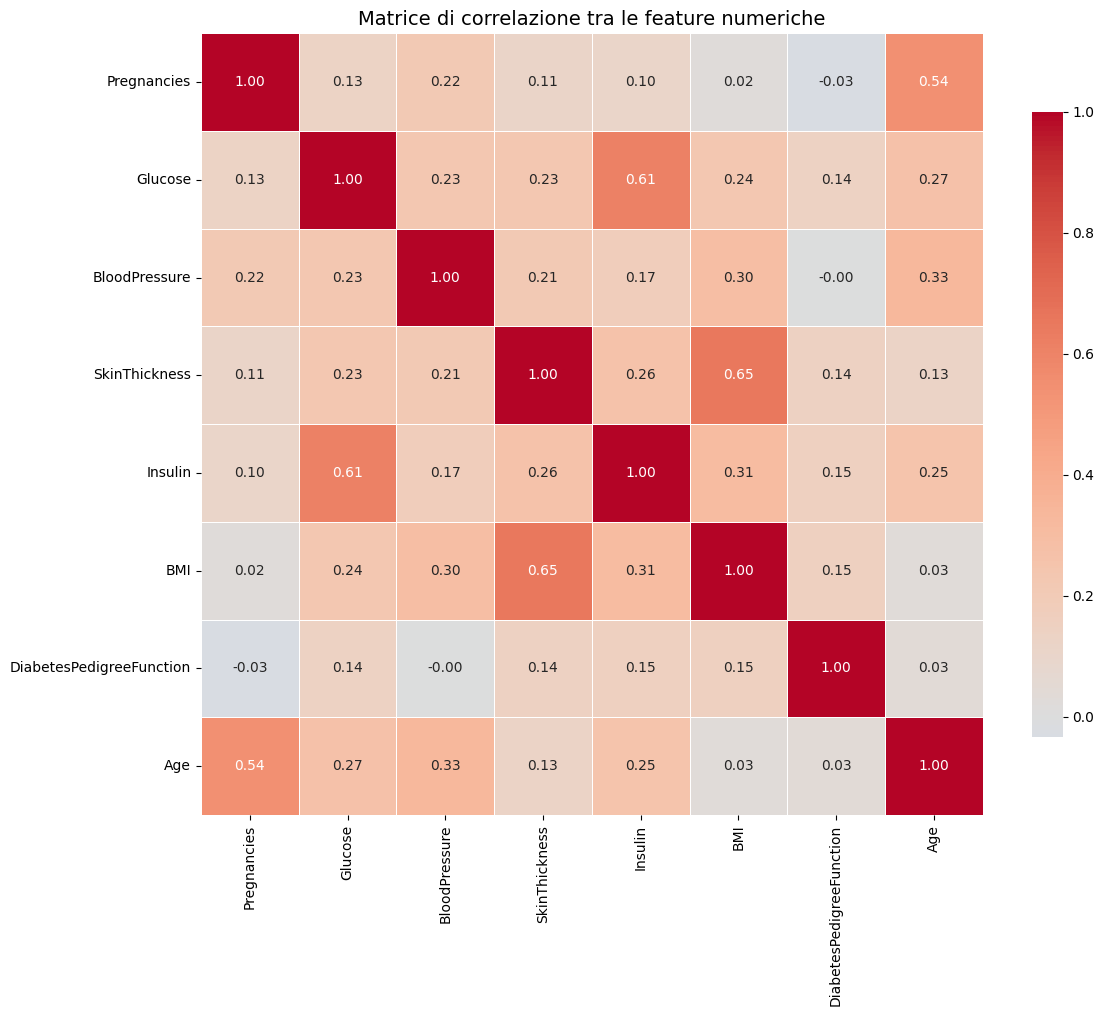

In [ ]:
#Feature numeriche (escludo il target)
numerical_cols = df.drop(columns=["Outcome"]).columns

# Calcolo matrice di correlazione (Pearson)
corr_matrix = df[numerical_cols].corr(method="pearson")

# Heatmap della correlazione
plt.figure(figsize=(12, 10))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Matrice di correlazione tra le feature numeriche", fontsize=14)
plt.tight_layout()
plt.show()



/tmp/ipython-input-448210201.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


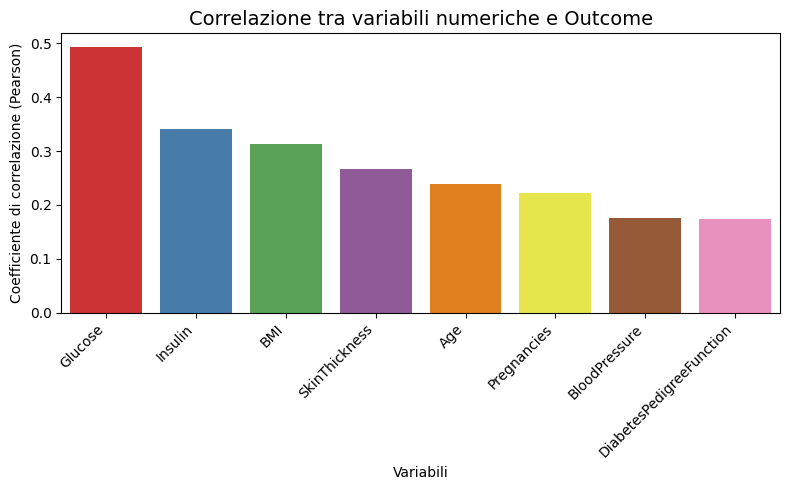

In [ ]:
target = "Outcome"

num_corr_cols = df.drop(columns=[target]).columns

# Correlazione feature–target (Pearson)
num_target_corr = (
    df[num_corr_cols]
    .corrwith(df[target], method="pearson")
    .sort_values(ascending=False)
)

num_target_corr_df = pd.DataFrame(
    num_target_corr,
    columns=["Correlation with Outcome"]
)

plt.figure(figsize=(8, 5))

sns.barplot(
    x=num_target_corr_df.index,
    y=num_target_corr_df["Correlation with Outcome"],
    palette="Set1"
)

plt.title("Correlazione tra variabili numeriche e Outcome", fontsize=14)
plt.ylabel("Coefficiente di correlazione (Pearson)")
plt.xlabel("Variabili")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()



# Preparazione dei modelli


In [ ]:
# Separazione delle feature e della variabile target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Split del dataset in training (80%) e test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


Lo StandardScaler serve a normalizzare le feature rendendo media zero e deviazione standard uno, così i modelli come SVM e reti neurali convergono più velocemente e lavorano meglio, evitando che variabili con scale diverse influenzino troppo il risultato.


In [ ]:
# Inizializzo lo scaler
scaler = StandardScaler()

# Fit SOLO sul training (evita data leakage)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# Neural Network
def create_neural_network_model(input_shape):
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# SVM
def create_and_train_svm_model(
    X_train,
    y_train,
    kernel='rbf',
    C=10
):
    model = SVC(
        kernel=kernel,
        C=C,
        class_weight="balanced",
        probability=True
    )
    model.fit(X_train, y_train)
    return model

# Logistic Regression
def create_and_train_logistic_regression(
    X_train,
    y_train,
    max_iters=1000
):
    model = LogisticRegression(
        max_iter=max_iters,
        class_weight="balanced"
    )
    model.fit(X_train, y_train)
    return model


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

def evaluate_model_performance(y_true, y_pred, model_name):

    # Metriche
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Report dettagliato
    print(f"\n{model_name} - Detailed Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

    # Riassunto
    print(f"\n{model_name} - Performance Metrics Summary:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}\n")

    # Plot Confusion Matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Predicted 0', 'Predicted 1'],
        yticklabels=['Actual 0', 'Actual 1'],
        cbar=False
    )
    plt.title(f'{model_name} - Confusion Matrix', fontsize=10)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Output metriche
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'True Negatives': cm[0, 0],
        'False Positives': cm[0, 1],
        'False Negatives': cm[1, 0],
        'True Positives': cm[1, 1]
    }



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_model_performance_metrics(metrics_list):

    # Converte le metriche in Dataframe
    metrics_df = pd.DataFrame(metrics_list)

    # Setup 2x4 della tabella
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('Model Performance Metrics Comparison', fontsize=14, fontweight='bold')


    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

    for i, metric in enumerate(metrics):
        ax = axs[0, i]
        metrics_df.plot(kind='bar', x='Model', y=metric, ax=ax, color=colors[i],
                        edgecolor='black', linewidth=1, alpha=0.7, legend=False)

        ax.set_title(metric, fontweight='bold', fontsize=11)
        ax.set_ylabel(metric)
        ax.set_xlabel('')
        ax.set_ylim(0, 1)
        ax.yaxis.grid(True, linestyle='--', alpha=0.6)

        for j, v in enumerate(metrics_df[metric]):
            ax.text(j, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # True Positives e True Negatives
    ax = axs[1, 0]
    true_plot = metrics_df.plot(kind='bar', x='Model', y=['True Positives', 'True Negatives'],
                                ax=ax, color=['#e74c3c', '#3498db'],
                                edgecolor='black', linewidth=1, alpha=0.7)
    ax.set_title('True Positives & True Negatives', fontweight='bold', fontsize=11)
    ax.set_ylabel('Count')
    ax.set_xlabel('')
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for container in true_plot.containers:
        true_plot.bar_label(container, fmt='%.0f', fontsize=9, fontweight='bold')

    # False Positives e False Negatives
    ax = axs[1, 1]
    false_plot = metrics_df.plot(kind='bar', x='Model', y=['False Positives', 'False Negatives'],
                                 ax=ax, color=['#2ecc71', '#f39c12'],
                                 edgecolor='black', linewidth=1, alpha=0.7)
    ax.set_title('False Positives & False Negatives', fontweight='bold', fontsize=11)
    ax.set_ylabel('Count')
    ax.set_xlabel('')
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for container in false_plot.containers:
        false_plot.bar_label(container, fmt='%.0f', fontsize=9, fontweight='bold')

    axs[1, 2].axis('off')
    axs[1, 3].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()


# Addestramento dei modelli

## Neural Network

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4217 - loss: 0.7650 - val_accuracy: 0.6341 - val_loss: 0.6414
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7539 - loss: 0.5771 - val_accuracy: 0.7154 - val_loss: 0.5750
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7618 - loss: 0.5214 - val_accuracy: 0.7398 - val_loss: 0.5471
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7715 - loss: 0.4732 - val_accuracy: 0.7398 - val_loss: 0.5316
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7192 - loss: 0.5069 - val_accuracy: 0.7398 - val_loss: 0.5255
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7740 - loss: 0.4434 - val_accuracy: 0.7398 - val_loss: 0.5209
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7730 - loss: 0.4457 - val_accuracy: 0.7480 - val_loss: 0.5146
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7793 - loss: 0.4334 - val_accuracy: 0.7480 - val_

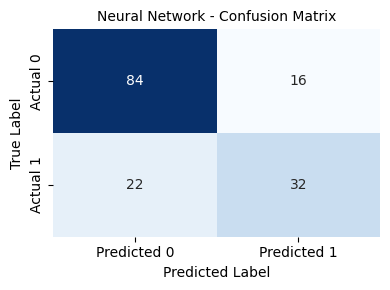

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


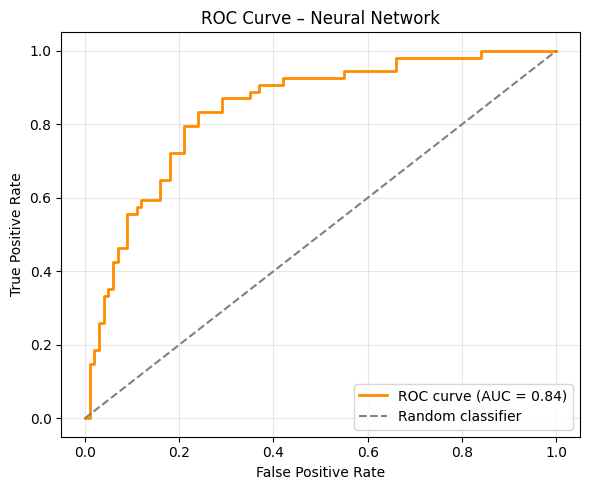

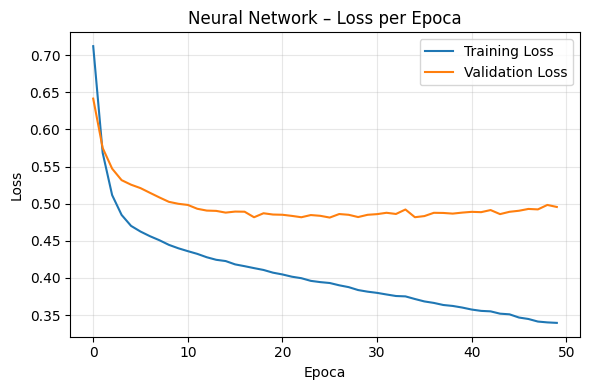

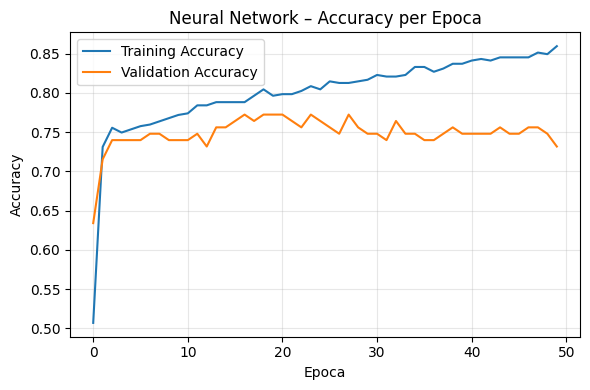

In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Definizione del modello
def create_neural_network_model(input_shape):
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

input_shape = (X_train.shape[1],)
nn_model = create_neural_network_model(input_shape)

# Addestramento con validation
history = nn_model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Predizioni (classi)
y_pred_nn = (nn_model.predict(X_test) > 0.5).astype(int)

# Valutazione
nn_metrics = evaluate_model_performance(
    y_test,
    y_pred_nn,
    "Neural Network"
    ,#cmap="Oranges"
)

# ROC Curve
y_prob_nn = nn_model.predict(X_test).ravel()

fpr, tpr, _ = roc_curve(y_test, y_prob_nn)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(
    fpr,
    tpr,
    lw=2,
    color="darkorange",
    label=f"ROC curve (AUC = {roc_auc:.2f})"
)
plt.plot(
    [0, 1],
    [0, 1],
    linestyle="--",
    color="gray",
    label="Random classifier"
)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Neural Network")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Training Curves - LOSS
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Neural Network – Loss per Epoca')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Training Curves - ACCURACY
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Neural Network – Accuracy per Epoca')
plt.xlabel('Epoca')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



## SVM


SVM - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       100
           1       0.65      0.74      0.69        54

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.75       154
weighted avg       0.78      0.77      0.77       154


SVM - Performance Metrics Summary:
Accuracy:  0.7662
Precision: 0.6452
Recall:    0.7407
F1 Score:  0.6897



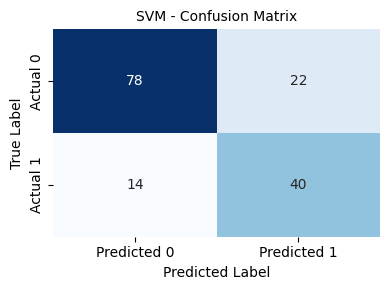

In [ ]:
# SVM
svm_model = create_and_train_svm_model( X_train, y_train )

# Predizioni
y_pred_svm = svm_model.predict(X_test)

# Valutazione
svm_metrics = evaluate_model_performance( y_test, y_pred_svm, "SVM" )

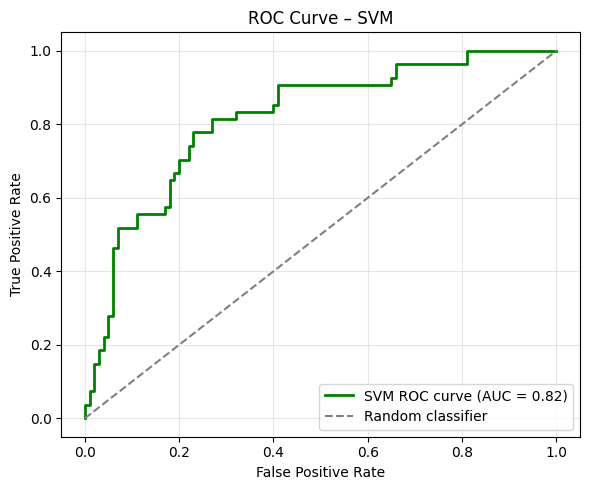

In [ ]:
# Probabilità predette (classe 1)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]

# Calcolo ROC
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(6, 5))
plt.plot(
    fpr_svm,
    tpr_svm,
    color='green',
    lw=2,
    label=f'SVM ROC curve (AUC = {roc_auc_svm:.2f})'
)
plt.plot(
    [0, 1], [0, 1],
    linestyle='--',
    color='gray',
    label='Random classifier'
)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – SVM')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Regressione Logistica


Logistic Regression - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       100
           1       0.65      0.69      0.67        54

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154


Logistic Regression - Performance Metrics Summary:
Accuracy:  0.7597
Precision: 0.6491
Recall:    0.6852
F1 Score:  0.6667



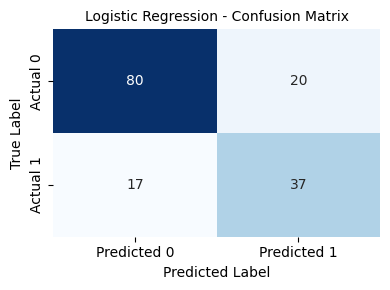

In [ ]:
# Logistic Regression
logreg_model = create_and_train_logistic_regression(
    X_train,
    y_train,
    max_iters=1000
)

# Predizioni
y_pred_lr = logreg_model.predict(X_test)


# Valutazione
logreg_metrics = evaluate_model_performance(
    y_test,
    y_pred_lr,
    "Logistic Regression"
)



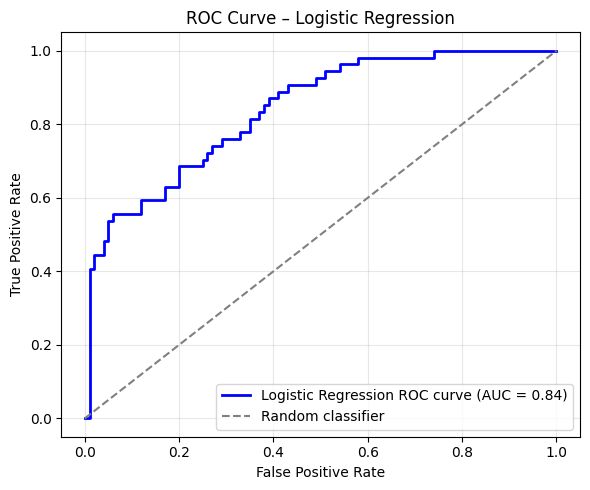

In [ ]:
# Probabilità predette (classe 1)
y_prob_lr = logreg_model.predict_proba(X_test)[:, 1]

# Calcolo ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(6, 5))
plt.plot(
    fpr_lr,
    tpr_lr,
    color='blue',
    lw=2,
    label=f'Logistic Regression ROC curve (AUC = {roc_auc_lr:.2f})'
)
plt.plot(
    [0, 1], [0, 1],
    linestyle='--',
    color='gray',
    label='Random classifier'
)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Logistic Regression')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Confrontro tra Modelli

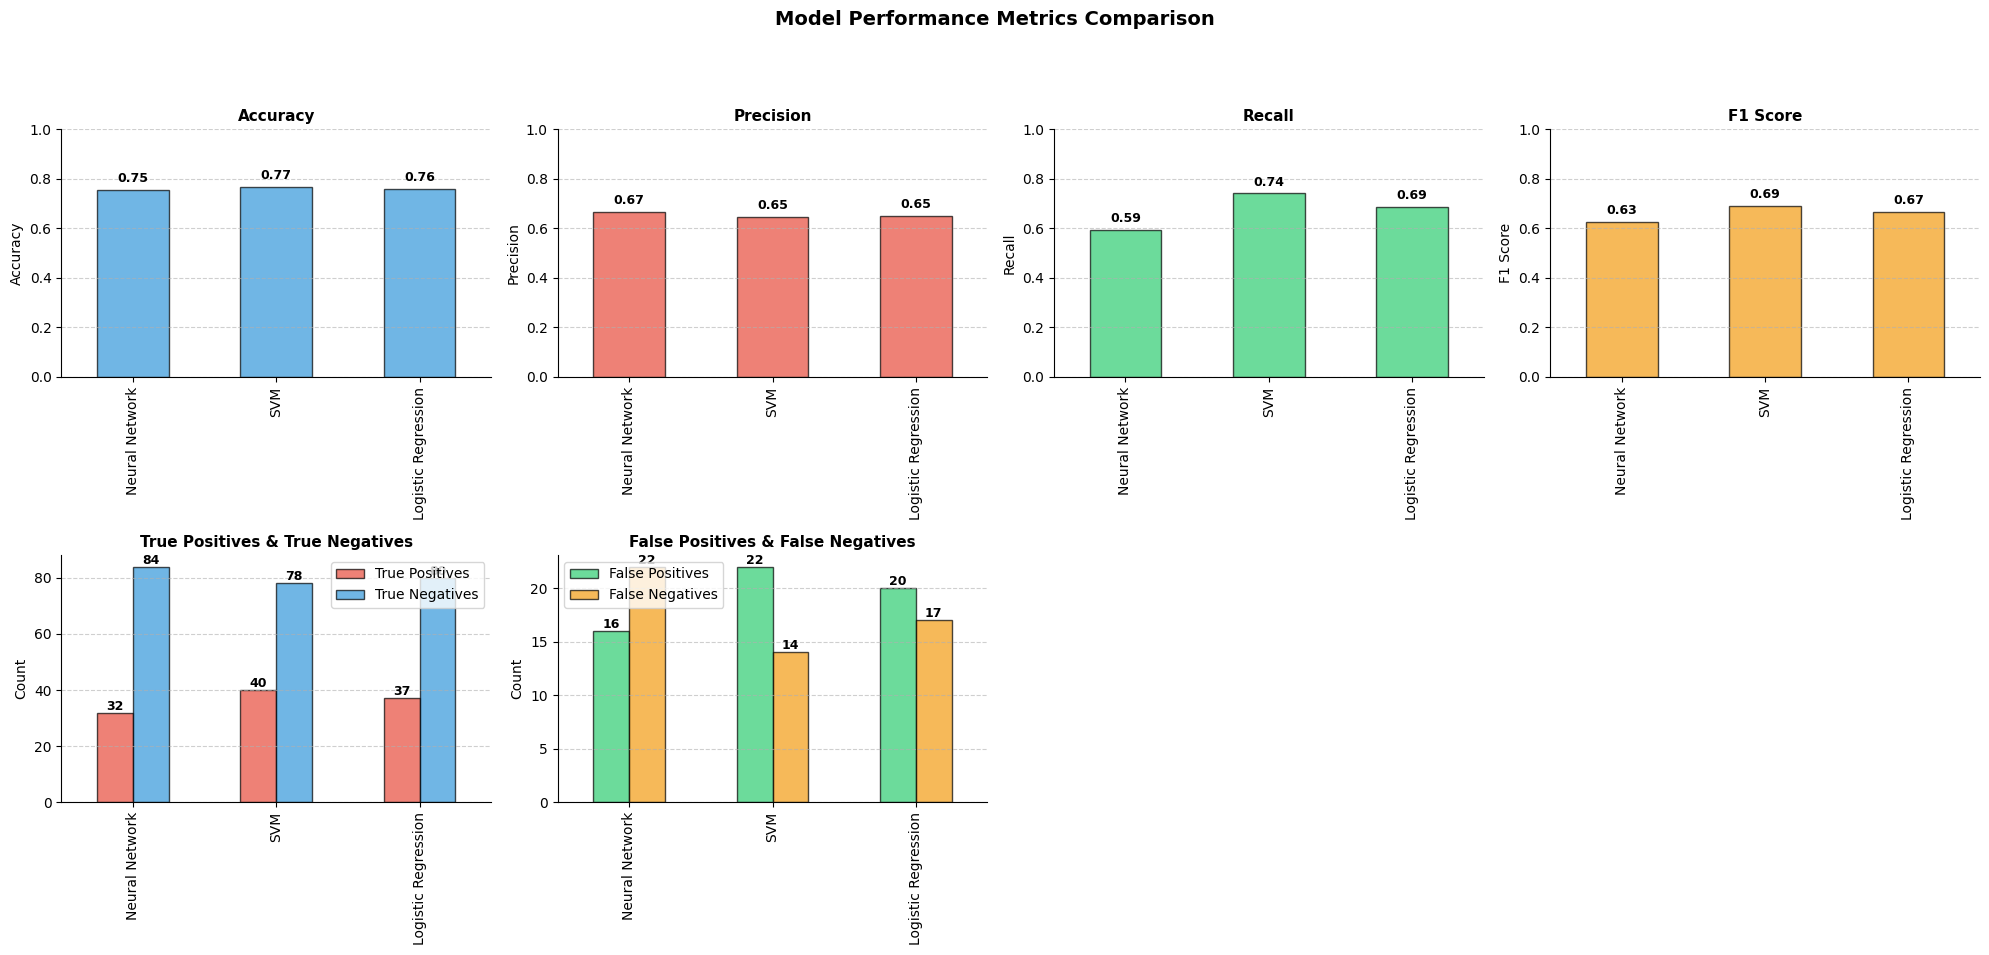

In [ ]:
# Confronto metriche baseline
baseline_metrics_list = [
    nn_metrics,
    svm_metrics,
    logreg_metrics
]

plot_model_performance_metrics(baseline_metrics_list)



# Sporcamento del dataset e analisi degli effetti

Al fine di analizzare la robustezza dei modelli di machine learning rispetto a dati imperfetti, sono state applicate diverse tecniche di sporcamento controllato del dataset, esclusivamente sul training set.

In particolare:

* **Inserimento di valori mancanti (NaN):** una percentuale dei valori delle feature viene sostituita con valori nulli, al fine di simulare dati incompleti dovuti a sensori non funzionanti o errori di acquisizione.

* **Aggiunta di rumore:** vengono perturbati i valori delle feature numeriche introducendo rumore casuale, simulando errori di misura o imprecisioni nei dati raccolti.

* **Duplicazione dei campioni:** alcune osservazioni del dataset vengono replicate, alterando la distribuzione dei dati e introducendo un bias artificiale che può influenzare il processo di apprendimento.

Queste tecniche permettono di valutare come la qualità dei dati influisca sulle prestazioni dei modelli e di identificare le variabili più critiche per il processo di classificazione.

**PREPROCESSING**

In [ ]:
def evaluate_model_performance(y_true, y_pred, model_name, cmap="Blues"):
    from sklearn.metrics import (
        accuracy_score,
        precision_score,
        recall_score,
        f1_score,
        confusion_matrix,
        classification_report
    )
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Metriche
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Report testuale
    print(f"\n{model_name} - Detailed Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

    print(f"\n{model_name} - Performance Metrics Summary:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}\n")

    # Plot matrice di confusione
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap=cmap,
        xticklabels=['Predicted 0', 'Predicted 1'],
        yticklabels=['Actual 0', 'Actual 1'],
        cbar=False
    )
    plt.title(f'{model_name} - Confusion Matrix', fontsize=10)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'True Negatives': cm[0, 0],
        'False Positives': cm[0, 1],
        'False Negatives': cm[1, 0],
        'True Positives': cm[1, 1]
    }


## Aggiunta valori nulli

In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Funzione: aggiunta valori NaN
def add_missing_values(X, missing_ratio, random_state=42):
    np.random.seed(random_state)
    X_missing = X.copy()

    n_total = X_missing.size
    n_missing = int(n_total * missing_ratio)

    rows = np.random.randint(0, X_missing.shape[0], n_missing)
    cols = np.random.randint(0, X_missing.shape[1], n_missing)

    X_missing.values[rows, cols] = np.nan
    return X_missing

### Addestramento


--- Missing Values: 10% ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Neural Network - 10% Missing - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       100
           1       0.64      0.70      0.67        54

    accuracy                           0.76       154
   macro avg       0.74      0.75      0.74       154
weighted avg       0.77      0.76      0.76       154


Neural Network - 10% Missing - Performance Metrics Summary:
Accuracy:  0.7597
Precision: 0.6441
Recall:    0.7037
F1 Score:  0.6726



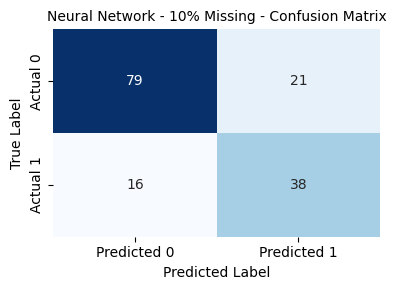


SVM - 10% Missing - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.71      0.77       100
           1       0.58      0.74      0.65        54

    accuracy                           0.72       154
   macro avg       0.71      0.73      0.71       154
weighted avg       0.75      0.72      0.73       154


SVM - 10% Missing - Performance Metrics Summary:
Accuracy:  0.7208
Precision: 0.5797
Recall:    0.7407
F1 Score:  0.6504



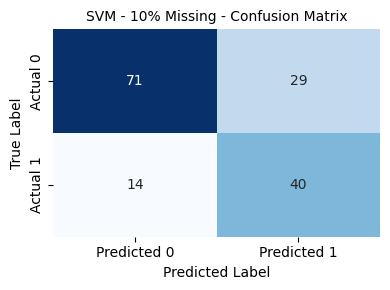


Logistic Regression - 10% Missing - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       100
           1       0.65      0.69      0.67        54

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154


Logistic Regression - 10% Missing - Performance Metrics Summary:
Accuracy:  0.7597
Precision: 0.6491
Recall:    0.6852
F1 Score:  0.6667



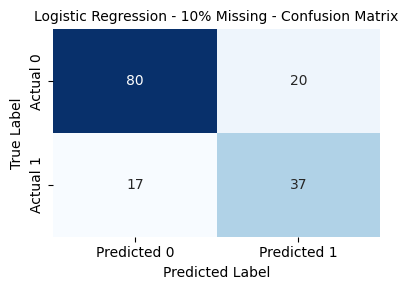


--- Missing Values: 20% ---
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Neural Network - 20% Missing - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.91      0.80       100
           1       0.65      0.31      0.42        54

    accuracy                           0.70       154
   macro avg       0.68      0.61      0.61       154
weighted avg       0.69      0.70      0.67       154


Neural Network - 20% Missing - Performance Metrics Summary:
Accuracy:  0.7013
Precision: 0.6538
Recall:    0.3148
F1 Score:  0.4250



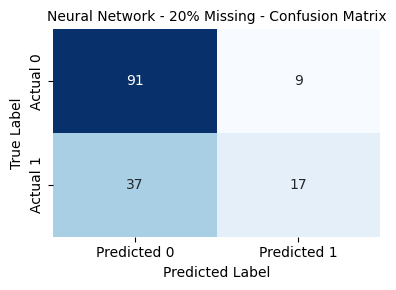


SVM - 20% Missing - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.72      0.78       100
           1       0.59      0.76      0.67        54

    accuracy                           0.73       154
   macro avg       0.72      0.74      0.72       154
weighted avg       0.76      0.73      0.74       154


SVM - 20% Missing - Performance Metrics Summary:
Accuracy:  0.7338
Precision: 0.5942
Recall:    0.7593
F1 Score:  0.6667



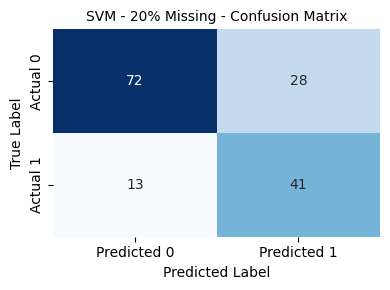


Logistic Regression - 20% Missing - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       100
           1       0.62      0.69      0.65        54

    accuracy                           0.74       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.75      0.74      0.74       154


Logistic Regression - 20% Missing - Performance Metrics Summary:
Accuracy:  0.7403
Precision: 0.6167
Recall:    0.6852
F1 Score:  0.6491



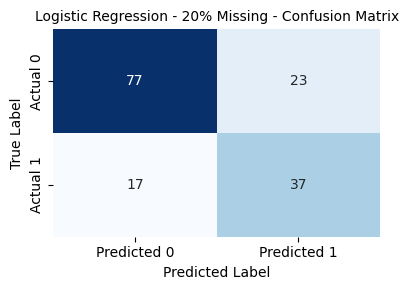


--- Missing Values: 30% ---


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Neural Network - 30% Missing - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       100
           1       1.00      0.02      0.04        54

    accuracy                           0.66       154
   macro avg       0.83      0.51      0.41       154
weighted avg       0.78      0.66      0.53       154


Neural Network - 30% Missing - Performance Metrics Summary:
Accuracy:  0.6558
Precision: 1.0000
Recall:    0.0185
F1 Score:  0.0364



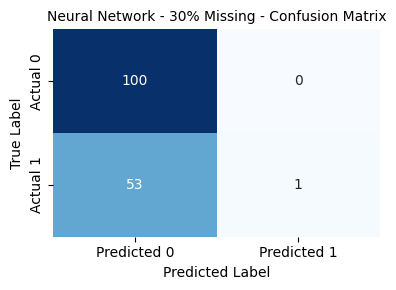


SVM - 30% Missing - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.67      0.74       100
           1       0.55      0.74      0.63        54

    accuracy                           0.69       154
   macro avg       0.69      0.71      0.69       154
weighted avg       0.73      0.69      0.70       154


SVM - 30% Missing - Performance Metrics Summary:
Accuracy:  0.6948
Precision: 0.5479
Recall:    0.7407
F1 Score:  0.6299



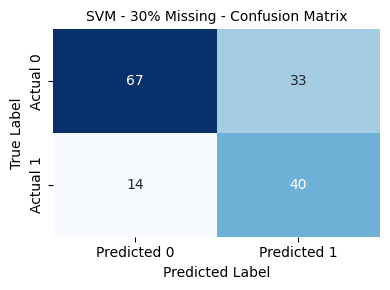


Logistic Regression - 30% Missing - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       100
           1       0.56      0.61      0.58        54

    accuracy                           0.69       154
   macro avg       0.67      0.68      0.67       154
weighted avg       0.70      0.69      0.70       154


Logistic Regression - 30% Missing - Performance Metrics Summary:
Accuracy:  0.6948
Precision: 0.5593
Recall:    0.6111
F1 Score:  0.5841



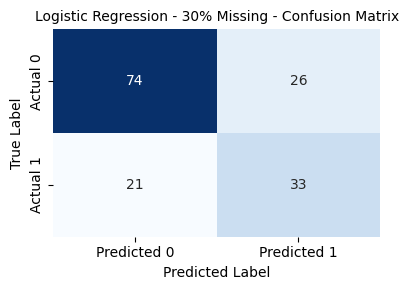

In [ ]:
missing_levels = [0.10, 0.20, 0.30]
all_missing_metrics = []

for level in missing_levels:
    print(f"\n--- Missing Values: {int(level*100)}% ---")

    # 1. Sporco SOLO le feature
    X_missing = add_missing_values(X, level)

    # 2. Train / Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_missing,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    # 3. Imputazione (media)
    imputer = SimpleImputer(strategy="mean")
    X_train_imp = imputer.fit_transform(X_train)
    X_test_imp = imputer.transform(X_test)

    # Neural Network
    input_shape = (X_train_imp.shape[1],)
    nn_model = create_neural_network_model(input_shape)

    nn_model.fit(
        X_train_imp,
        y_train,
        epochs=50,
        batch_size=32,
        verbose=0
    )

    y_pred_nn = (nn_model.predict(X_test_imp) > 0.5).astype(int)
    nn_metrics = evaluate_model_performance(
        y_test,
        y_pred_nn,
        f"Neural Network - {int(level*100)}% Missing"
    )

    nn_metrics["Missing %"] = int(level * 100)
    nn_metrics["Model"] = "Neural Network"
    all_missing_metrics.append(nn_metrics)

    # SVM
    svm_model = create_and_train_svm_model(X_train_imp, y_train)
    y_pred_svm = svm_model.predict(X_test_imp)

    svm_metrics = evaluate_model_performance(
        y_test,
        y_pred_svm,
        f"SVM - {int(level*100)}% Missing"
    )

    svm_metrics["Missing %"] = int(level * 100)
    svm_metrics["Model"] = "SVM"
    all_missing_metrics.append(svm_metrics)

    # Logistic Regression
    lr_model = create_and_train_logistic_regression(
        X_train_imp,
        y_train,
        max_iters=1000
    )

    y_pred_lr = lr_model.predict(X_test_imp)

    lr_metrics = evaluate_model_performance(
        y_test,
        y_pred_lr,
        f"Logistic Regression - {int(level*100)}% Missing"
    )

    lr_metrics["Missing %"] = int(level * 100)
    lr_metrics["Model"] = "Logistic Regression"
    all_missing_metrics.append(lr_metrics)


### Confronto

In [ ]:
import pandas as pd

metrics_df = pd.DataFrame(all_missing_metrics)


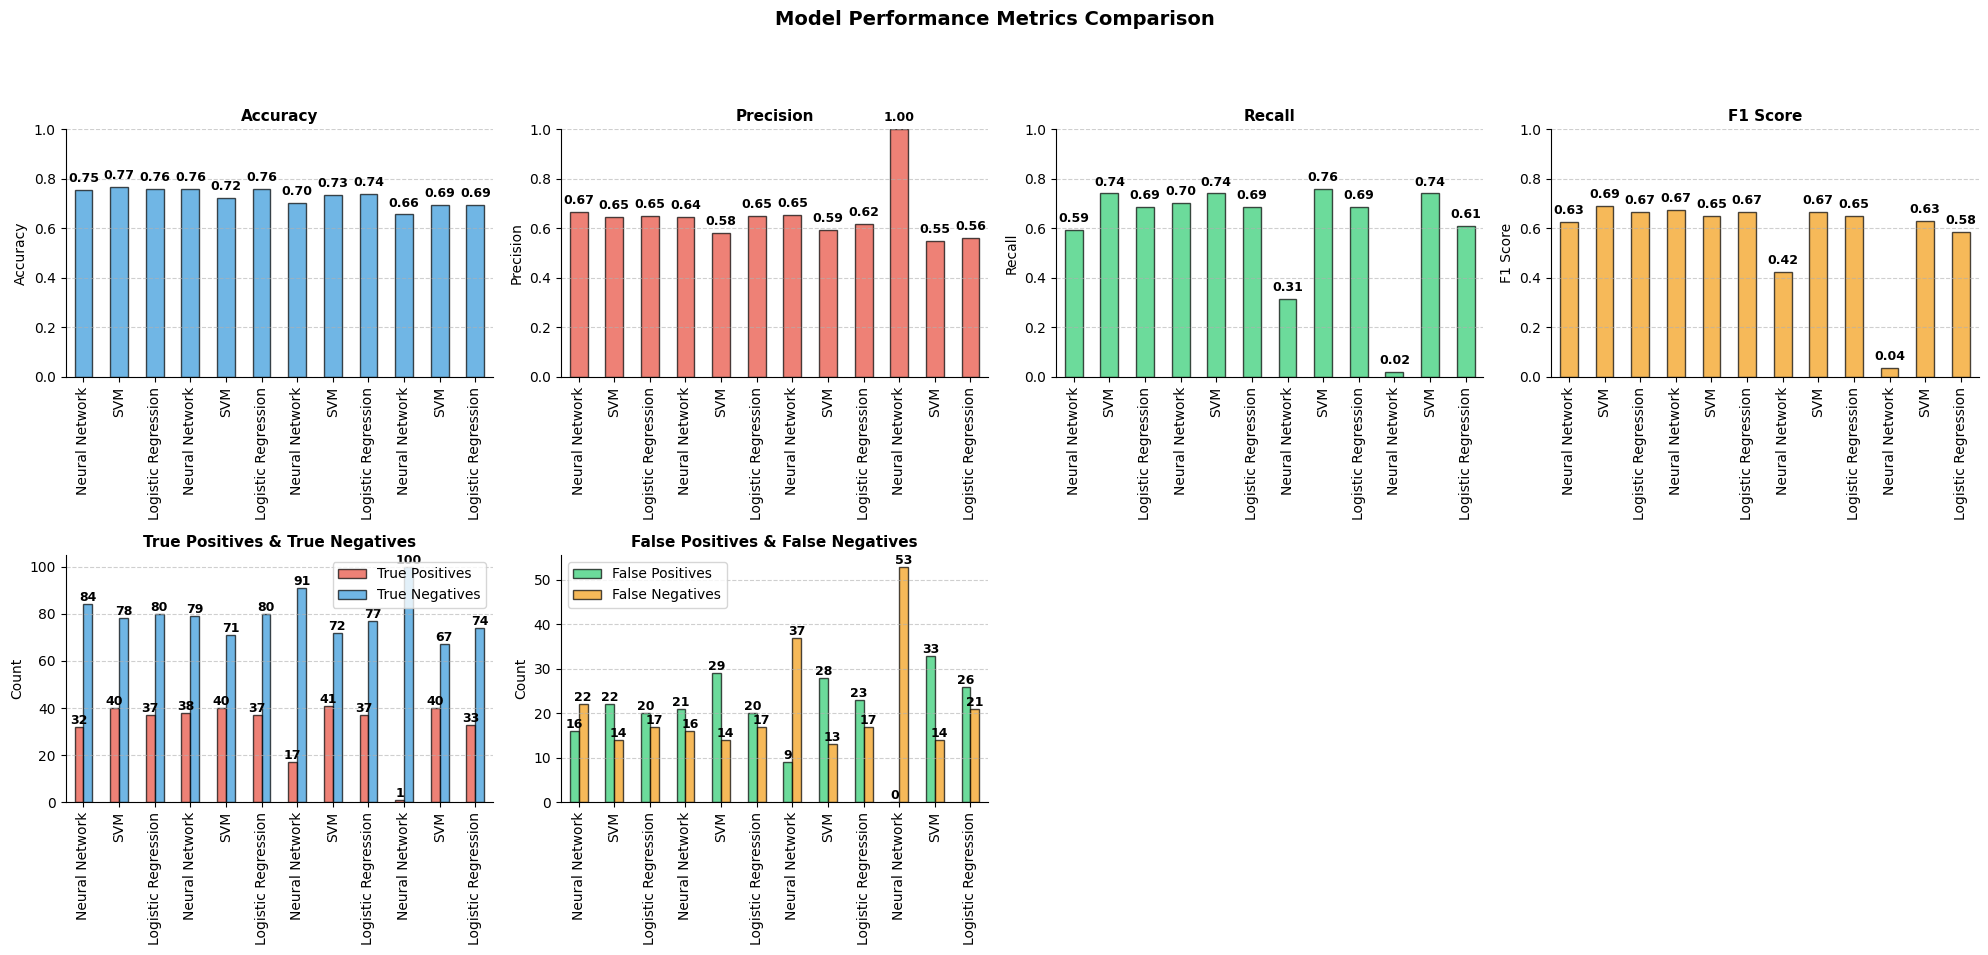

In [ ]:
# Confronto finale con baseline
full_null_metrics_list = baseline_metrics_list + all_missing_metrics
plot_model_performance_metrics(full_null_metrics_list)

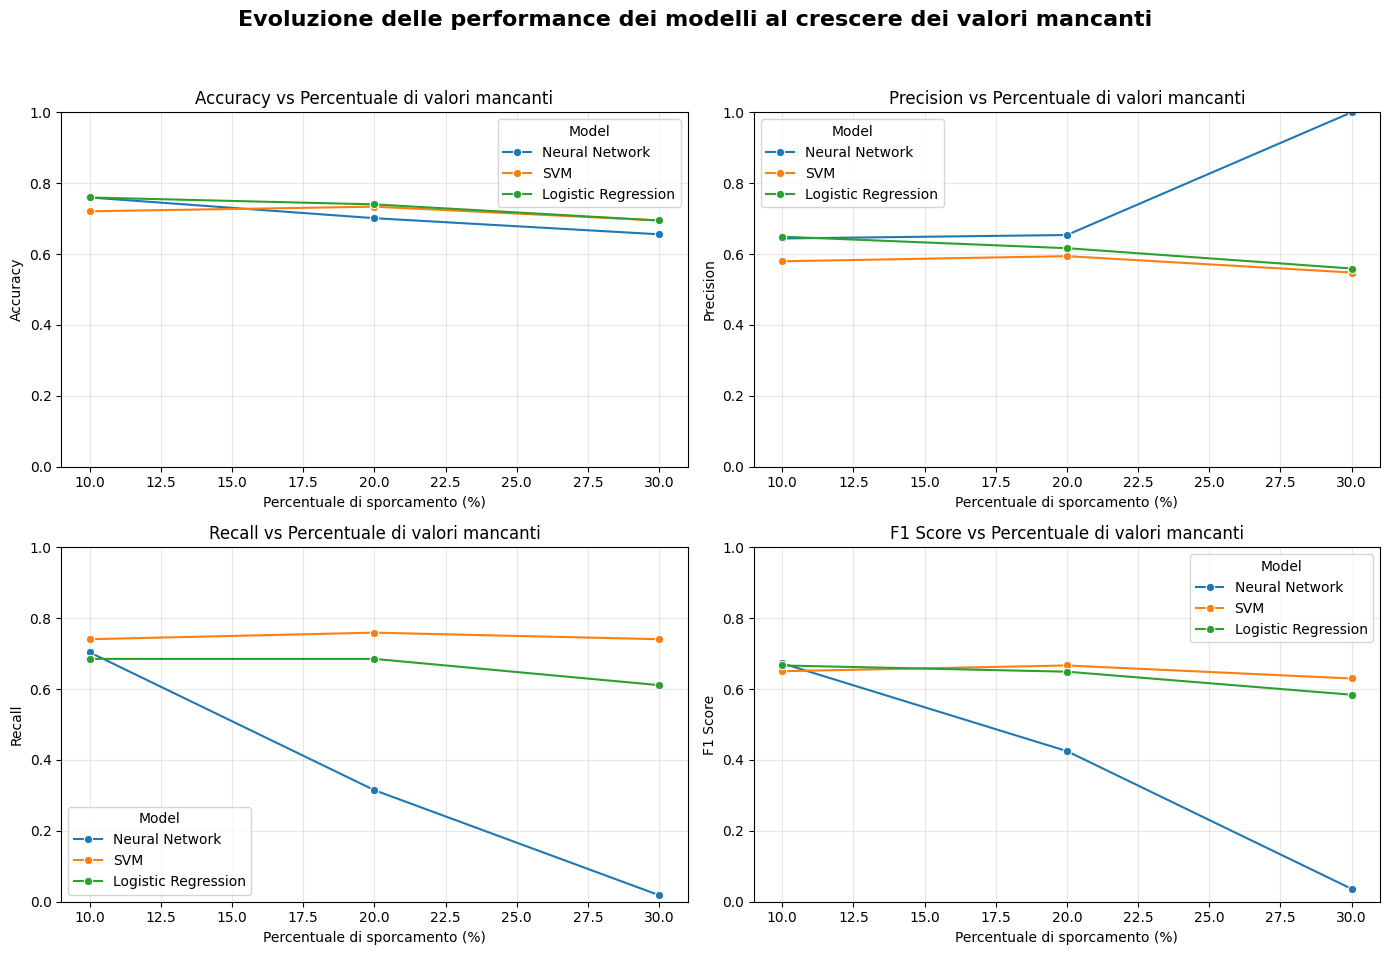

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1 Score"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    sns.lineplot(
        data=metrics_df,
        x="Missing %",
        y=metric,
        hue="Model",
        marker="o",
        ax=axes[i]
    )
    axes[i].set_title(f"{metric} vs Percentuale di valori mancanti")
    axes[i].set_xlabel("Percentuale di sporcamento (%)")
    axes[i].set_ylabel(metric)
    axes[i].set_ylim(0, 1)
    axes[i].grid(True, alpha=0.3)

plt.suptitle(
    "Evoluzione delle performance dei modelli al crescere dei valori mancanti",
    fontsize=16,
    fontweight="bold"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Aggiunta del rumore

In [ ]:
def add_noise(X, noise_level):
    X_noisy = X.copy()
    # Rumore gaussiano con media 0 e std = noise_level * std dei dati
    for col in X_noisy.columns:
        std = X_noisy[col].std()
        noise = np.random.normal(0, noise_level * std, size=X_noisy.shape[0])
        X_noisy[col] += noise
    return X_noisy


### Addestramento


--- Noise Level: 5% ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

NN - Noise 5% - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       100
           1       0.76      0.59      0.67        54

    accuracy                           0.79       154
   macro avg       0.78      0.75      0.76       154
weighted avg       0.79      0.79      0.79       154


NN - Noise 5% - Performance Metrics Summary:
Accuracy:  0.7922
Precision: 0.7619
Recall:    0.5926
F1 Score:  0.6667



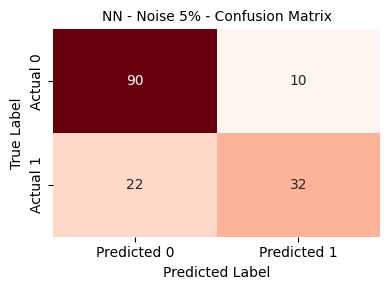


SVM - Noise 5% - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       100
           1       0.64      0.69      0.66        54

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.76       154


SVM - Noise 5% - Performance Metrics Summary:
Accuracy:  0.7532
Precision: 0.6379
Recall:    0.6852
F1 Score:  0.6607



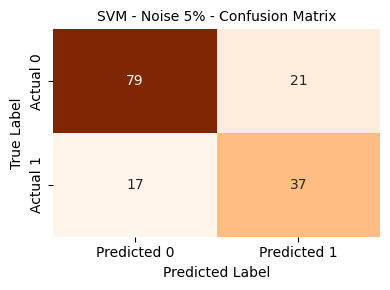


LR - Noise 5% - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       100
           1       0.64      0.67      0.65        54

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.76      0.75      0.75       154


LR - Noise 5% - Performance Metrics Summary:
Accuracy:  0.7532
Precision: 0.6429
Recall:    0.6667
F1 Score:  0.6545



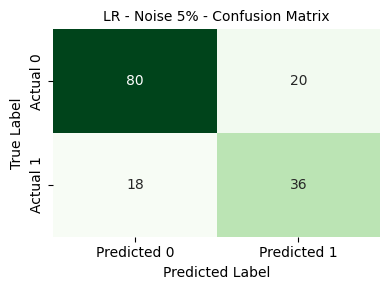


--- Noise Level: 10% ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

NN - Noise 10% - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       100
           1       0.72      0.57      0.64        54

    accuracy                           0.77       154
   macro avg       0.76      0.73      0.74       154
weighted avg       0.77      0.77      0.77       154


NN - Noise 10% - Performance Metrics Summary:
Accuracy:  0.7727
Precision: 0.7209
Recall:    0.5741
F1 Score:  0.6392



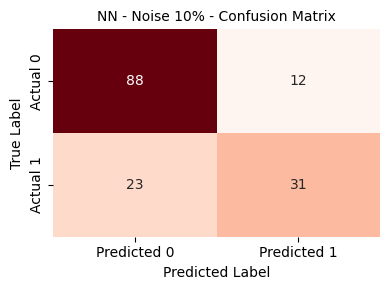


SVM - Noise 10% - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       100
           1       0.63      0.67      0.65        54

    accuracy                           0.75       154
   macro avg       0.72      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154


SVM - Noise 10% - Performance Metrics Summary:
Accuracy:  0.7468
Precision: 0.6316
Recall:    0.6667
F1 Score:  0.6486



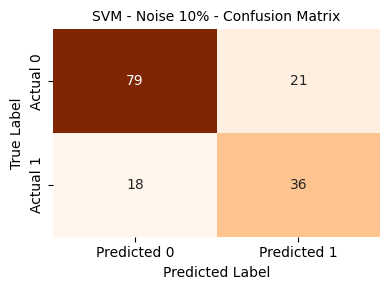


LR - Noise 10% - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       100
           1       0.65      0.69      0.67        54

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154


LR - Noise 10% - Performance Metrics Summary:
Accuracy:  0.7597
Precision: 0.6491
Recall:    0.6852
F1 Score:  0.6667



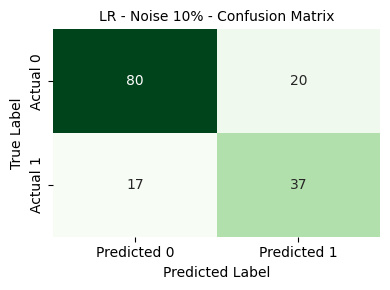


--- Noise Level: 20% ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

NN - Noise 20% - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       100
           1       0.73      0.59      0.65        54

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.77      0.78      0.77       154


NN - Noise 20% - Performance Metrics Summary:
Accuracy:  0.7792
Precision: 0.7273
Recall:    0.5926
F1 Score:  0.6531



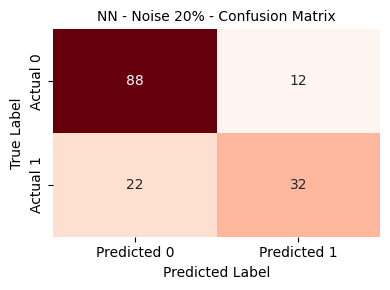


SVM - Noise 20% - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       100
           1       0.68      0.70      0.69        54

    accuracy                           0.78       154
   macro avg       0.76      0.76      0.76       154
weighted avg       0.78      0.78      0.78       154


SVM - Noise 20% - Performance Metrics Summary:
Accuracy:  0.7792
Precision: 0.6786
Recall:    0.7037
F1 Score:  0.6909



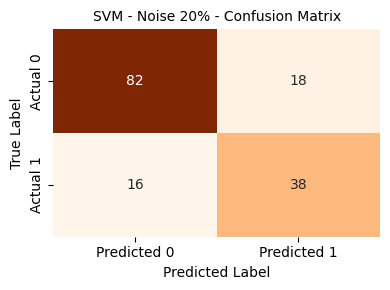


LR - Noise 20% - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       100
           1       0.66      0.69      0.67        54

    accuracy                           0.77       154
   macro avg       0.74      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154


LR - Noise 20% - Performance Metrics Summary:
Accuracy:  0.7662
Precision: 0.6607
Recall:    0.6852
F1 Score:  0.6727



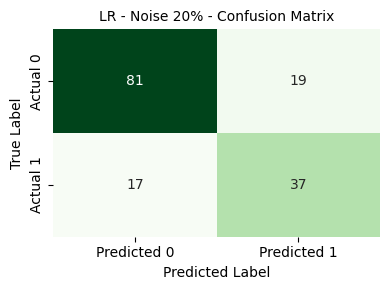

In [ ]:
# Livelli di rumore
noise_levels = [0.05, 0.1, 0.2]
all_noise_metrics = []

for level in noise_levels:
    print(f"\n--- Noise Level: {int(level*100)}% ---")

    # 1. Split pulito
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    # 2. Aggiunta rumore SOLO al training set
    X_train_noisy = add_noise(X_train, level)

    # 3. Standardizzazione
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_noisy)
    X_test_scaled = scaler.transform(X_test)

    # Neural Network
    nn_model = create_neural_network_model((X_train_scaled.shape[1],))
    nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

    y_pred_nn = (nn_model.predict(X_test_scaled) > 0.5).astype(int)
    nn_metrics = evaluate_model_performance(
        y_test,
        y_pred_nn,
        f"NN - Noise {int(level*100)}%",
        cmap="Reds"
    )

    # SVM
    svm_model = create_and_train_svm_model(X_train_scaled, y_train)
    y_pred_svm = svm_model.predict(X_test_scaled)
    svm_metrics = evaluate_model_performance(
        y_test,
        y_pred_svm,
        f"SVM - Noise {int(level*100)}%",
        cmap="Oranges"
    )

    # Logistic Regression
    logreg_model = create_and_train_logistic_regression(
        X_train_scaled,
        y_train,
        max_iters=1000
    )
    y_pred_lr = logreg_model.predict(X_test_scaled)
    logreg_metrics = evaluate_model_performance(
        y_test,
        y_pred_lr,
        f"LR - Noise {int(level*100)}%",
        cmap="Greens"
    )

    # 4. Salvataggio metriche
    all_noise_metrics.extend([
        nn_metrics,
        svm_metrics,
        logreg_metrics
    ])


### Confronto

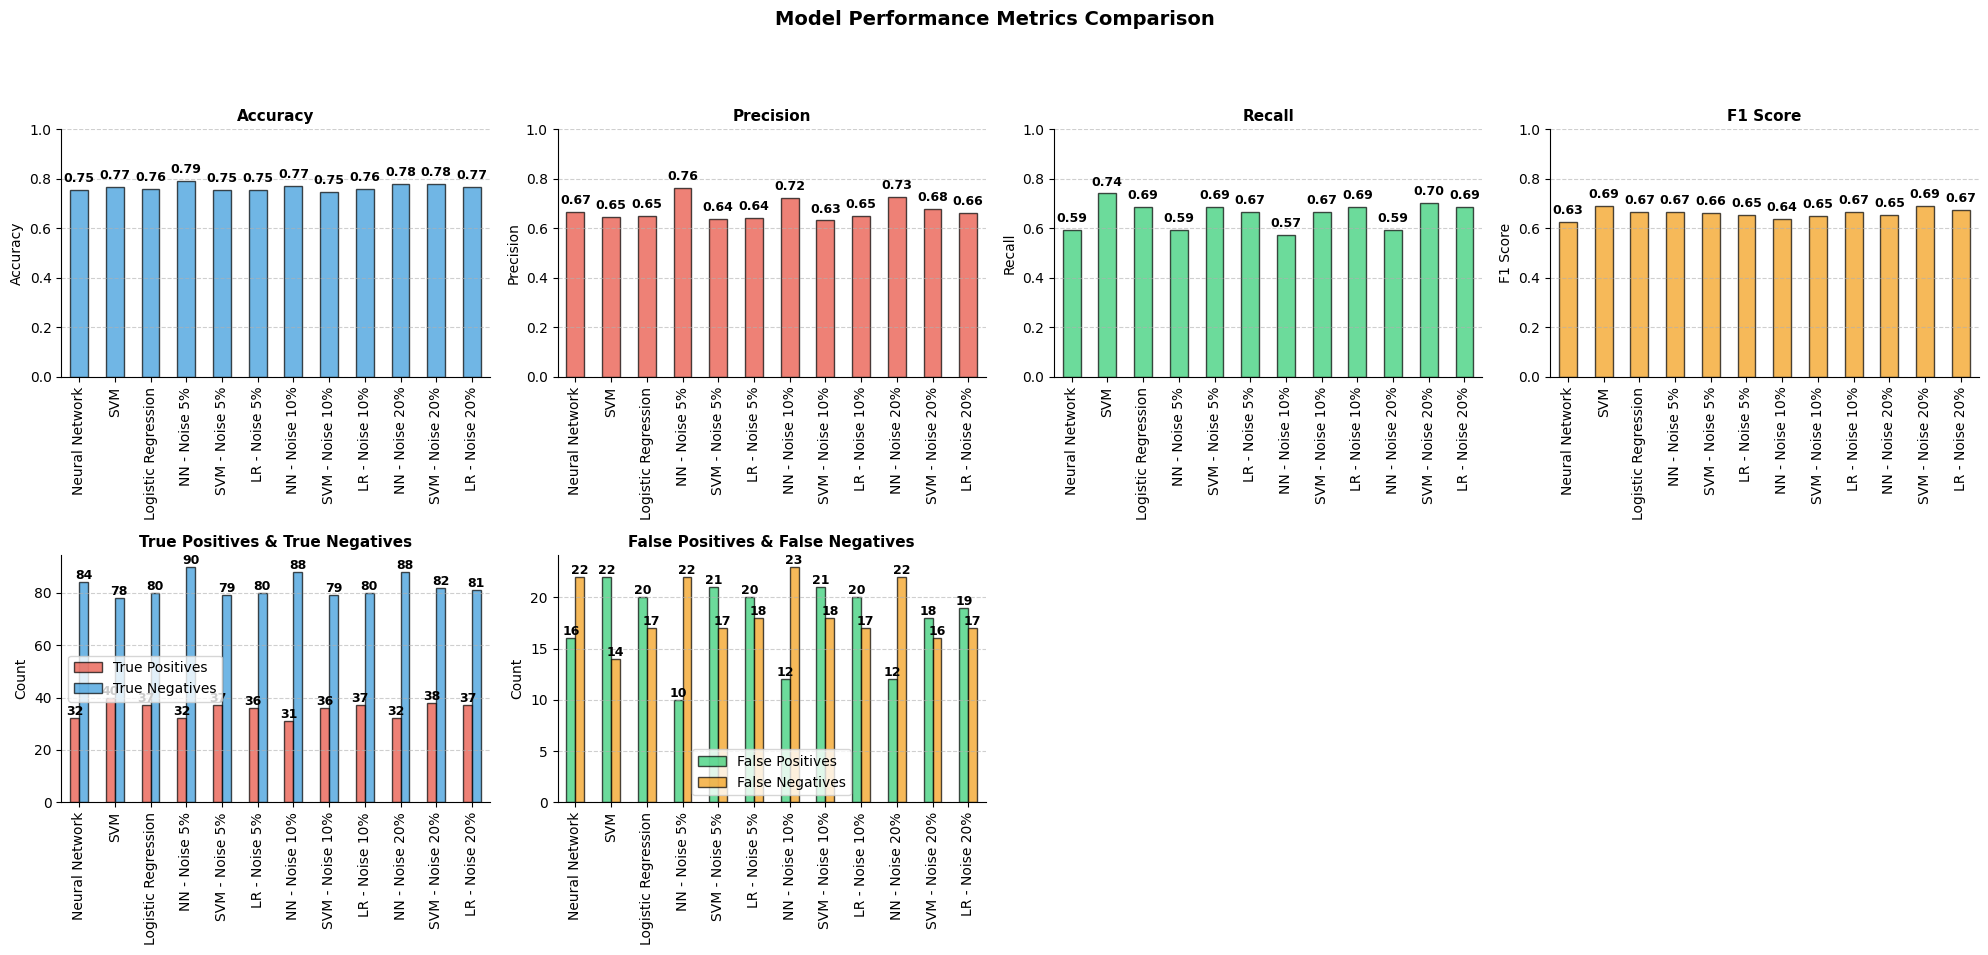

In [ ]:
# Confronto baseline + rumore
full_noise_metrics_list = baseline_metrics_list + all_noise_metrics

plot_model_performance_metrics(full_noise_metrics_list)


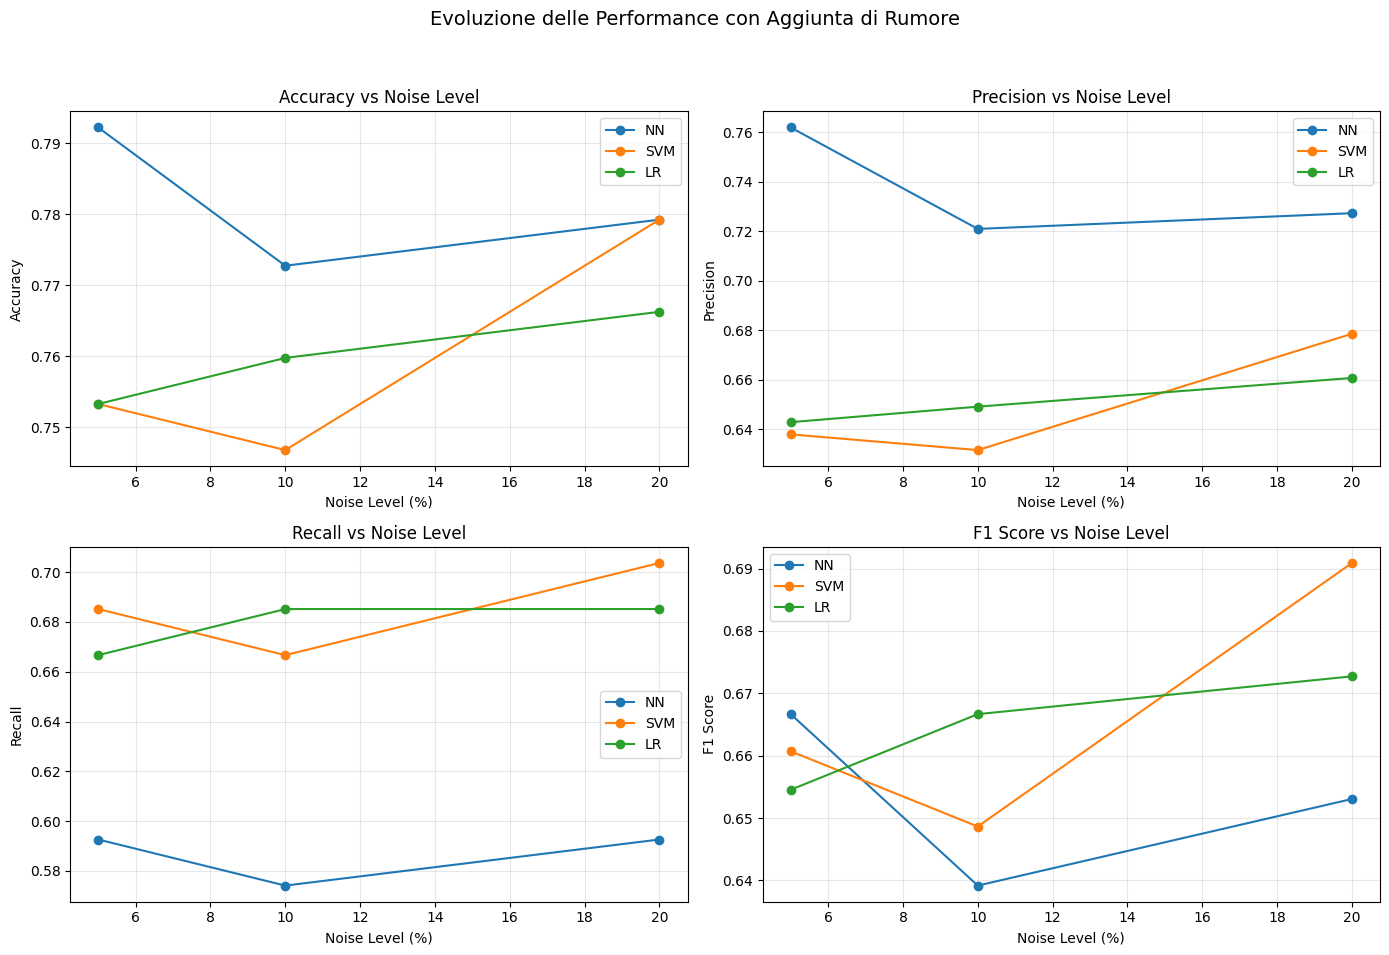

In [ ]:
# Grafico evoluzione metriche vs rumore
import pandas as pd
import matplotlib.pyplot as plt

noise_df = pd.DataFrame(all_noise_metrics)
noise_df["Noise Level"] = noise_df["Model"].str.extract(r'(\d+)').astype(int)

metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
models = ["NN", "SVM", "LR"]
colors = {"NN": "tab:blue", "SVM": "tab:orange", "LR": "tab:green"}

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    ax = axs[i]
    for model in models:
        model_df = noise_df[noise_df["Model"].str.contains(model)]
        ax.plot(
            model_df["Noise Level"],
            model_df[metric],
            marker="o",
            label=model,
            color=colors[model]
        )
    ax.set_title(f"{metric} vs Noise Level")
    ax.set_xlabel("Noise Level (%)")
    ax.set_ylabel(metric)
    ax.grid(alpha=0.3)
    ax.legend()

plt.suptitle("Evoluzione delle Performance con Aggiunta di Rumore", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Aggiunta valori duplicati

In [ ]:
# Funzione per aggiungere duplicati solo al training set
def add_duplicates(X_train, y_train, duplicate_ratio, random_state=42):
    np.random.seed(random_state)

    n_dup = int(len(X_train) * duplicate_ratio)
    dup_indices = np.random.choice(
        X_train.index,
        n_dup,
        replace=False
    )

    X_dup = pd.concat([X_train, X_train.loc[dup_indices]])
    y_dup = pd.concat([y_train, y_train.loc[dup_indices]])

    return X_dup, y_dup


### Addestramento


--- Duplicate Ratio: 10% ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

NN - Dup 10% - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       100
           1       0.73      0.59      0.65        54

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.77      0.78      0.77       154


NN - Dup 10% - Performance Metrics Summary:
Accuracy:  0.7792
Precision: 0.7273
Recall:    0.5926
F1 Score:  0.6531



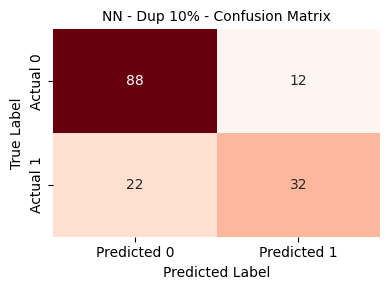


SVM - Dup 10% - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       100
           1       0.65      0.69      0.67        54

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154


SVM - Dup 10% - Performance Metrics Summary:
Accuracy:  0.7597
Precision: 0.6491
Recall:    0.6852
F1 Score:  0.6667



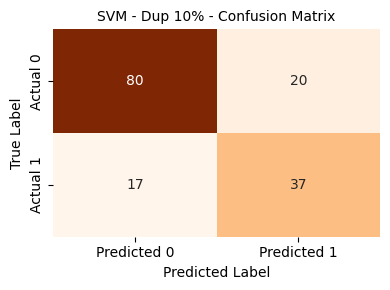


LR - Dup 10% - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       100
           1       0.64      0.67      0.65        54

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.76      0.75      0.75       154


LR - Dup 10% - Performance Metrics Summary:
Accuracy:  0.7532
Precision: 0.6429
Recall:    0.6667
F1 Score:  0.6545



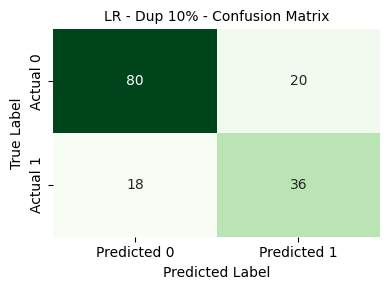


--- Duplicate Ratio: 20% ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

NN - Dup 20% - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       100
           1       0.67      0.57      0.62        54

    accuracy                           0.75       154
   macro avg       0.73      0.71      0.72       154
weighted avg       0.75      0.75      0.75       154


NN - Dup 20% - Performance Metrics Summary:
Accuracy:  0.7532
Precision: 0.6739
Recall:    0.5741
F1 Score:  0.6200



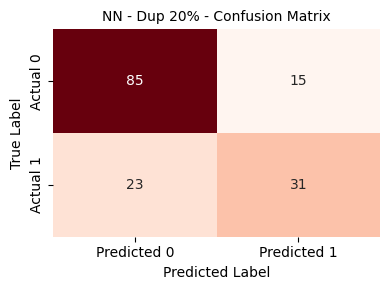


SVM - Dup 20% - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       100
           1       0.66      0.65      0.65        54

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.74       154
weighted avg       0.76      0.76      0.76       154


SVM - Dup 20% - Performance Metrics Summary:
Accuracy:  0.7597
Precision: 0.6604
Recall:    0.6481
F1 Score:  0.6542



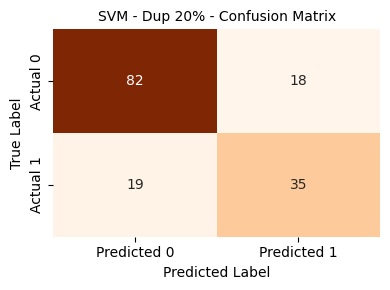


LR - Dup 20% - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       100
           1       0.65      0.65      0.65        54

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154


LR - Dup 20% - Performance Metrics Summary:
Accuracy:  0.7532
Precision: 0.6481
Recall:    0.6481
F1 Score:  0.6481



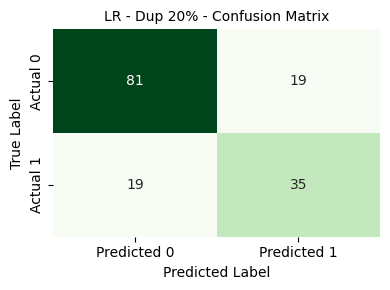


--- Duplicate Ratio: 30% ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

NN - Dup 30% - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       100
           1       0.69      0.65      0.67        54

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.75       154
weighted avg       0.77      0.77      0.77       154


NN - Dup 30% - Performance Metrics Summary:
Accuracy:  0.7727
Precision: 0.6863
Recall:    0.6481
F1 Score:  0.6667



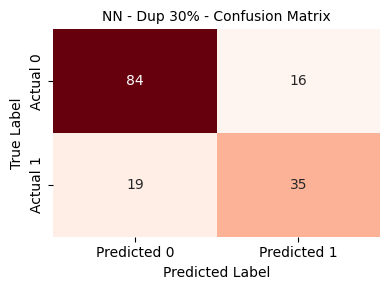


SVM - Dup 30% - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       100
           1       0.63      0.69      0.65        54

    accuracy                           0.75       154
   macro avg       0.72      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154


SVM - Dup 30% - Performance Metrics Summary:
Accuracy:  0.7468
Precision: 0.6271
Recall:    0.6852
F1 Score:  0.6549



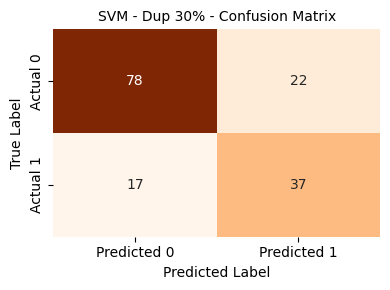


LR - Dup 30% - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       100
           1       0.62      0.65      0.64        54

    accuracy                           0.74       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.74      0.74      0.74       154


LR - Dup 30% - Performance Metrics Summary:
Accuracy:  0.7403
Precision: 0.6250
Recall:    0.6481
F1 Score:  0.6364



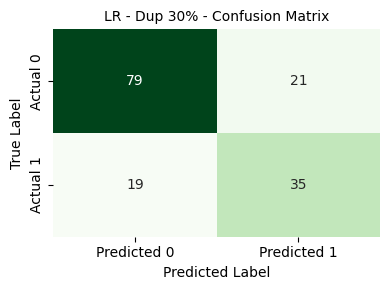

In [ ]:
# Livelli di duplicazione
duplicate_levels = [0.1, 0.2, 0.3]
all_duplicate_metrics = []

for level in duplicate_levels:
    print(f"\n--- Duplicate Ratio: {int(level*100)}% ---")

    # 1. Split pulito
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    # 2. Aggiunta duplicati SOLO al training
    X_train_dup, y_train_dup = add_duplicates(
        X_train,
        y_train,
        duplicate_ratio=level
    )

    # 3. Standardizzazione
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_dup)
    X_test_scaled = scaler.transform(X_test)

    # Neural Network
    nn_model = create_neural_network_model((X_train_scaled.shape[1],))
    nn_model.fit(X_train_scaled, y_train_dup, epochs=50, batch_size=32, verbose=0)

    y_pred_nn = (nn_model.predict(X_test_scaled) > 0.5).astype(int)
    nn_metrics = evaluate_model_performance(
        y_test,
        y_pred_nn,
        f"NN - Dup {int(level*100)}%",
        cmap="Reds"
    )

    # SVM
    svm_model = create_and_train_svm_model(X_train_scaled, y_train_dup)
    y_pred_svm = svm_model.predict(X_test_scaled)
    svm_metrics = evaluate_model_performance(
        y_test,
        y_pred_svm,
        f"SVM - Dup {int(level*100)}%",
        cmap="Oranges"
    )

    # Logistic Regression
    logreg_model = create_and_train_logistic_regression(
        X_train_scaled,
        y_train_dup,
        max_iters=1000
    )
    y_pred_lr = logreg_model.predict(X_test_scaled)
    logreg_metrics = evaluate_model_performance(
        y_test,
        y_pred_lr,
        f"LR - Dup {int(level*100)}%",
        cmap="Greens"
    )

    # 4. Salvataggio metriche
    all_duplicate_metrics.extend([
        nn_metrics,
        svm_metrics,
        logreg_metrics
    ])



### Confronto

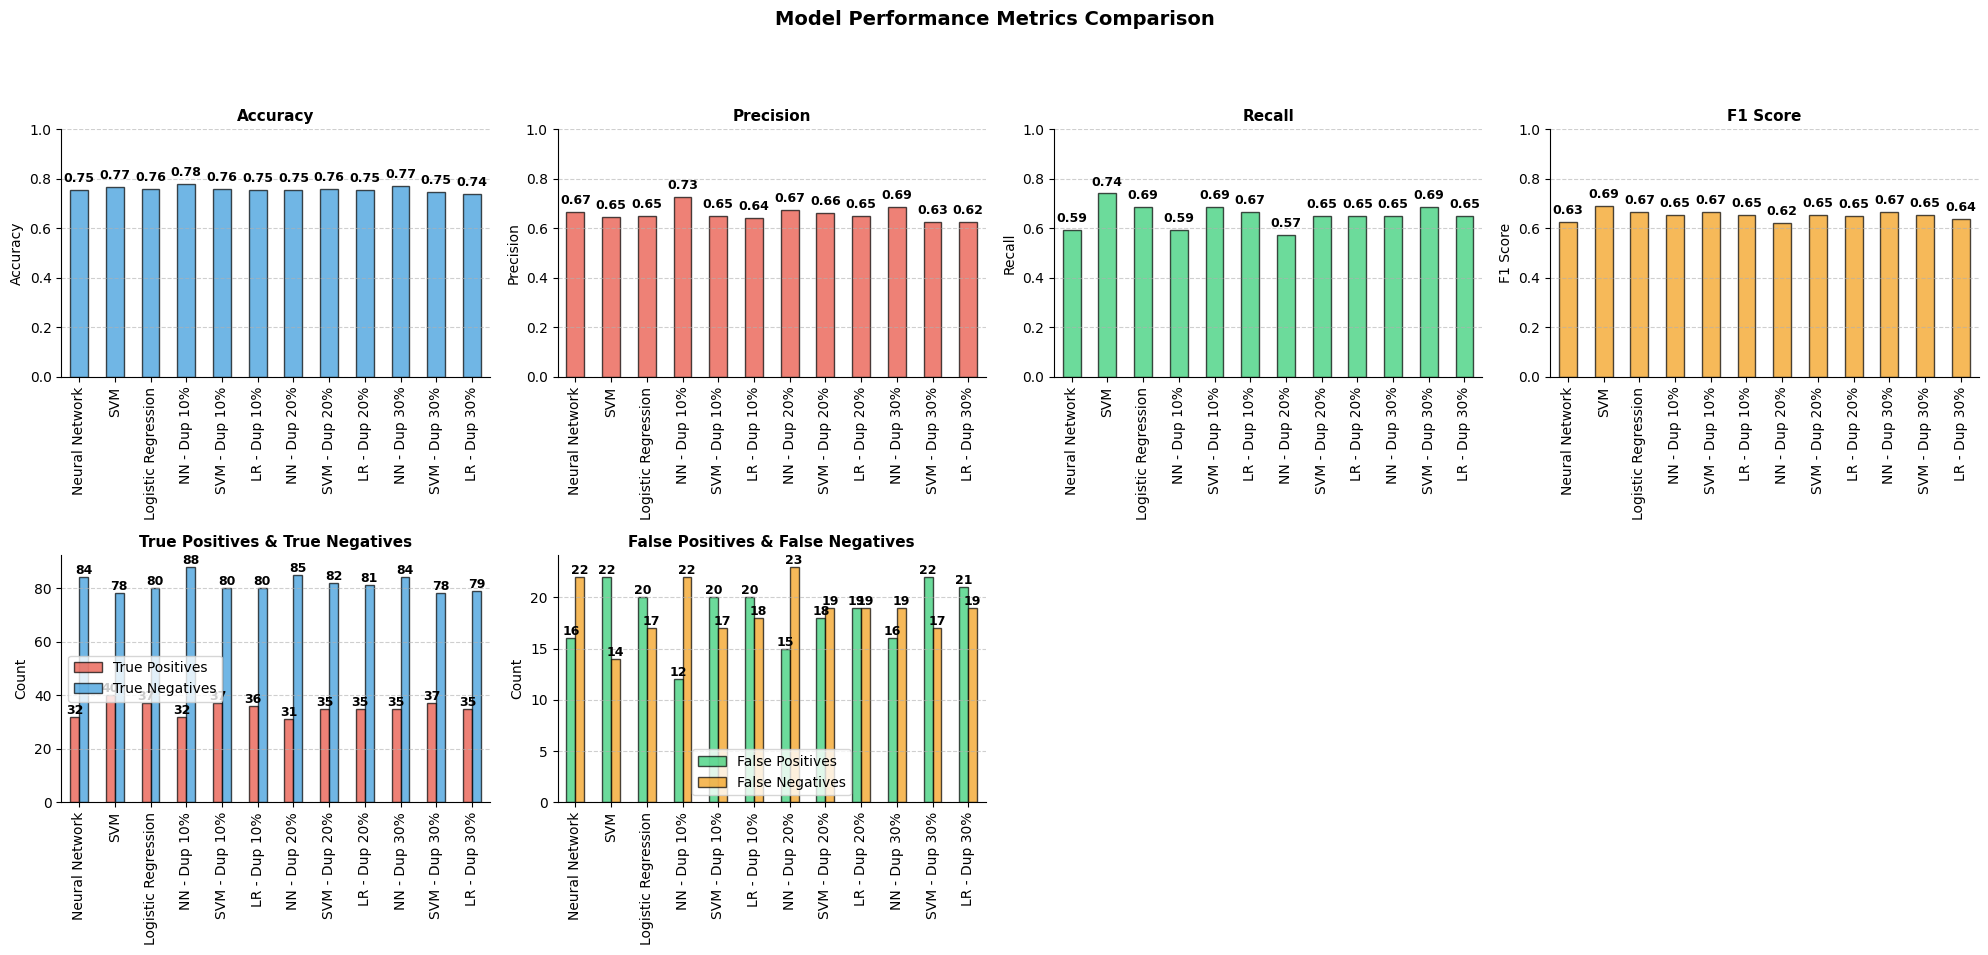

In [ ]:
# Confronto baseline
full_metrics_list_duplicates = baseline_metrics_list + all_duplicate_metrics

plot_model_performance_metrics(full_metrics_list_duplicates)


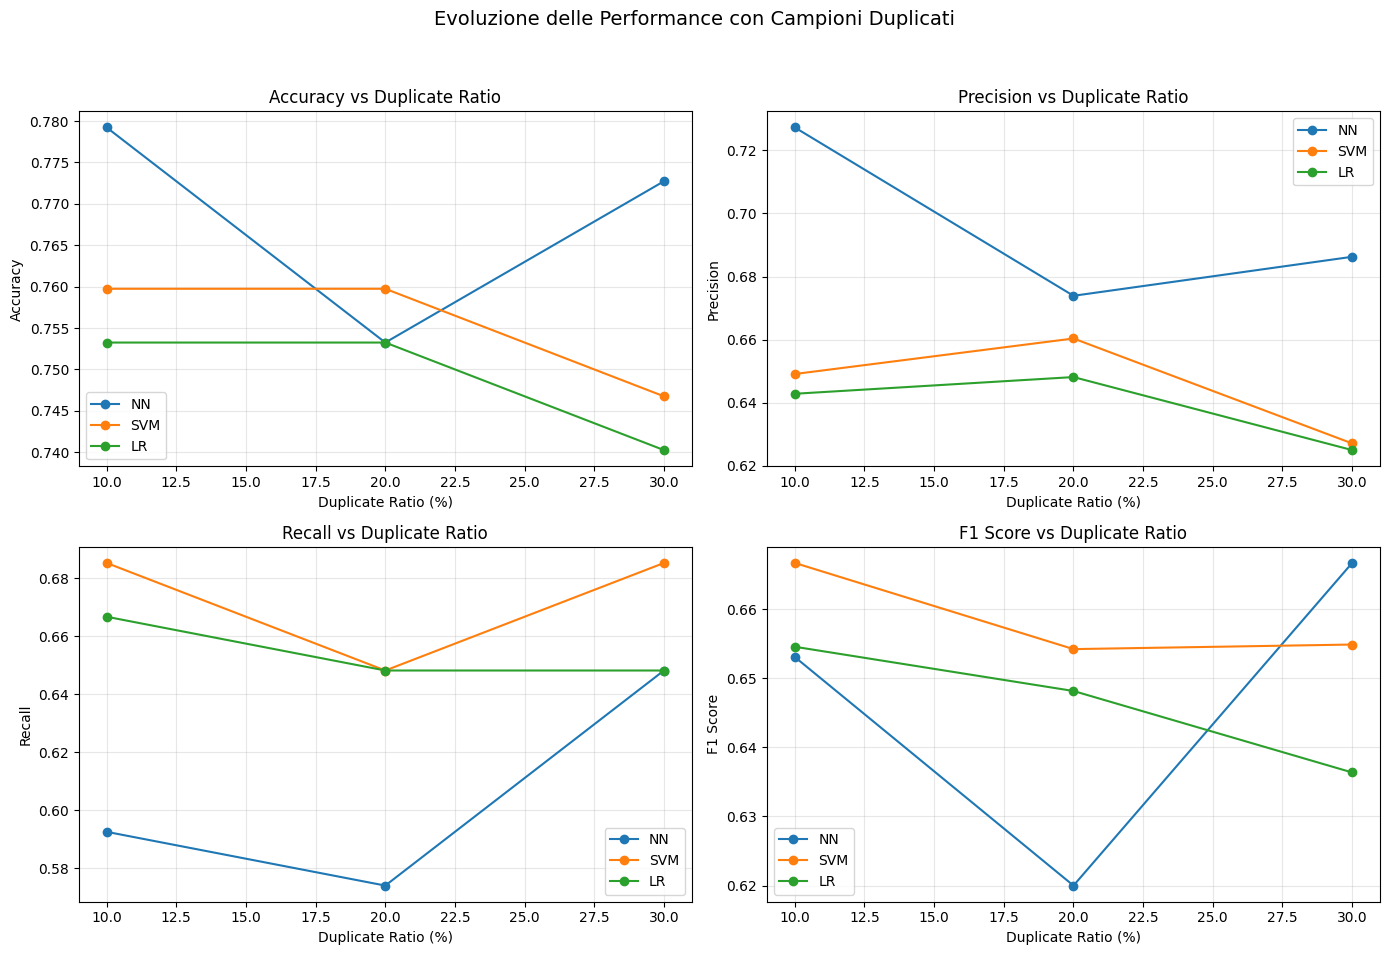

In [ ]:
# Evoluzione delle metriche vs duplicazione
dup_df = pd.DataFrame(all_duplicate_metrics)
dup_df["Duplicate Level"] = dup_df["Model"].str.extract(r'(\d+)').astype(int)

metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
models = ["NN", "SVM", "LR"]
colors = {"NN": "tab:blue", "SVM": "tab:orange", "LR": "tab:green"}

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    ax = axs[i]
    for model in models:
        model_df = dup_df[dup_df["Model"].str.contains(model)]
        ax.plot(
            model_df["Duplicate Level"],
            model_df[metric],
            marker="o",
            label=model,
            color=colors[model]
        )
    ax.set_title(f"{metric} vs Duplicate Ratio")
    ax.set_xlabel("Duplicate Ratio (%)")
    ax.set_ylabel(metric)
    ax.grid(alpha=0.3)
    ax.legend()

plt.suptitle("Evoluzione delle Performance con Campioni Duplicati", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
